In [1]:
import pandas as pd
import cmocean as cmo
import math
import gsw as gsw
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.special import kv as K_nu
from speccy import sick_tricks as gary
from speccy import ut

import xarray as xr
import seaborn as sns
import numpy as np
import pickle
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [25, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams.update({'font.size': 13})

# Data Processing and Cleaning

## Import csv file 

In [66]:
KIM400_parameter  = pd.read_csv('KIM400 Model fit parameters.csv')  
KIM200_parameter  = pd.read_csv('KIM200 Model fit parameters.csv')  
PIL200_parameter  = pd.read_csv('PIL200 Model fit parameters.csv')   
ITFTIS_parameter  = pd.read_csv('ITFTIS Model fit parameters.csv') 
NWSROW_parameter  = pd.read_csv('NWSROW Model fit parameters.csv')  

In [68]:
def read_pickle(file_name):
    
    # Load data from the file
    with open('{}'.format(file_name), 'rb') as f:
        result = pickle.load(f)
        
    return result[0]

In [70]:
KIM400_Model_fit_Eg = read_pickle('KIM400 model fit P3.pkl')
KIM200_Model_fit_Eg = read_pickle('KIM200 model fit P3.pkl')
PIL200_Model_fit_Eg = read_pickle('PIL200 model fit P3.pkl')
ITFTIS_Model_fit_Eg = read_pickle('ITFTIS model fit P6.pkl')
NWSROW_Model_fit_Eg = read_pickle('NWS model fit P1.pkl')

In [72]:
Whole_site_list = [PIL200_parameter,NWSROW_parameter,KIM200_parameter,KIM400_parameter,ITFTIS_parameter]
Whole_site_list = [PIL200_parameter,KIM200_parameter,KIM400_parameter,ITFTIS_parameter]
Whole_Soln_df = pd.concat(Whole_site_list)

In [74]:
Whole_Soln_df_M1L2 = Whole_Soln_df[Whole_Soln_df['model_type']=='M1L2']
Whole_Soln_df_M1L1 = Whole_Soln_df[Whole_Soln_df['model_type']=='M1L1']

## Cal percentage of variability

In [77]:
#reset index
Whole_Soln_df_M1L2.reset_index(drop=True,inplace=True)
#Add a depth round for easy gourp
Whole_Soln_df_M1L2 =Whole_Soln_df_M1L2.assign(depth_round = round(Whole_Soln_df_M1L2['depth']/5)*5)

Whole_Soln_df_M1L2['var_subset'] = Whole_Soln_df_M1L2['HA_var']+Whole_Soln_df_M1L2['var_modulated']
Whole_Soln_df_M1L2['var_subtidal_sqrt'] = np.sqrt(Whole_Soln_df_M1L2['var_subtidal'])
Whole_Soln_df_M1L2['HA_var%'] = Whole_Soln_df_M1L2['HA_var']/Whole_Soln_df_M1L2['var_subset']*100
Whole_Soln_df_M1L2['var_model-fit%'] = Whole_Soln_df_M1L2['var_model-fit']/Whole_Soln_df_M1L2['var_subset']*100
Whole_Soln_df_M1L2['var_model-fit_NPL%'] = Whole_Soln_df_M1L2['var_model-fit']/Whole_Soln_df_M1L2['var_modulated']*100

## Adjust season confusion from year 2012-2014 in ITFTIS

In [80]:
#Those code is modifying the season confusion from year 2012-2014 in ITFTIS

# Filter the DataFrame
B = Whole_Soln_df_M1L2[(Whole_Soln_df_M1L2['site'] == 'ITFTIS') & (Whole_Soln_df_M1L2['year'] < 2015) & (Whole_Soln_df_M1L2['year'] > 2011)]

# Define season labels
season_label_list = ['Feb-Apr', 'May-Jul', 'Aug-Oct', 'Nov-Jan']

# Iterate over unique years
for year in B['year'].unique():
    # Filter the DataFrame for the current year
    df_year = B[B['year'] == year]
    
    # Get unique months in the current year
    df_year['month'] = pd.to_datetime(df_year['start_date']).dt.month
    unique_months = df_year['month'].unique()
    
    # Sort unique months in ascending order
    unique_months.sort()
    
    # Assign seasons based on the order of appearance of months
    for month_order, month in enumerate(unique_months):
        season = season_label_list[month_order]
        # Update 'season' column for rows with the current month in the original DataFrame
        Whole_Soln_df_M1L2.loc[(Whole_Soln_df_M1L2['site'] == 'ITFTIS')
                               & (Whole_Soln_df_M1L2['year'] == year) 
                               & (pd.to_datetime(Whole_Soln_df_M1L2['start_date']).dt.month == month), 'season'] = season

C:\Users\21924032\AppData\Local\Temp\ipykernel_50932\55192058.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['month'] = pd.to_datetime(df_year['start_date']).dt.month


## Find the rows where model parameters are too close to boundary

In [83]:
#Parameter boudary
##bounds
bound_η_matern = [0.01,2]
bound_α_matern = [0.5,3.5] #impact the slope                  # from matern 7/2 to matern 0
bound_eta = [0.01,1]     # peak
bound_ℓ_exp = [0.01,40]  #impact how wide the brodening of peak is (reverse proportional)  
tolerance = 1.01

In [85]:
index_list_close_to_boundary = []
first_loc = Whole_Soln_df_M1L2.columns.get_loc('η_c')
for index, covparams in Whole_Soln_df_M1L2.iloc[:, first_loc:first_loc+6].iterrows():
    if (bound_η_matern[0]*tolerance < covparams['η_c']  < bound_η_matern[1]/tolerance) & (
        bound_α_matern[0]*tolerance < covparams['α_c']  < bound_α_matern[1]/tolerance) & (
        bound_eta[0]     *tolerance < covparams['η_D1'] < bound_eta[1]     /tolerance) & (
        bound_ℓ_exp[0]   *tolerance < covparams['τ_D1'] < bound_ℓ_exp[1]   /tolerance) & (
        bound_eta[0]     *tolerance < covparams['η_D2'] < bound_eta[1]     /tolerance) & (
        bound_ℓ_exp[0]   *tolerance < covparams['τ_D2'] < bound_ℓ_exp[1]   /tolerance):
        #do nothing
        pass
    else:
        index_list_close_to_boundary.append(index)
        
# Whole_Soln_df_M1L2.iloc[index_list_close_to_boundary]

## Find the rows where LR is significant

In [88]:
#Testing
#when ω >> λ:
def Asymptote_Matern(ff, params,lmbda=3):
    eta = params[0]
    alpha = params[1]
    
    ff = 2*np.pi*ff
    lmbda = 2*np.pi*lmbda
    c = (gamma(1 / 2) * gamma(alpha - 1 / 2)) / (2 * gamma(alpha) * np.pi)
    S = np.power(eta, 2) * np.power(lmbda, 2 * alpha - 1) / c
    #when w >> λ:
    S *= np.power(np.power(ff, 2), -alpha)
    return S

#when ω >> ω_0:
#when ω >> ω_0+1/l_exp:
def Asymptote_LR(f, params):
    eta   = params[0]
    l_exp = params[1]   # day
    f = 2*np.pi*f
    c = 2*np.pi/l_exp   # radius^-1
    return np.power(eta, 2.)*c*2/(f**2 )


# from speccy import acf
def matern(dx, params,lmbda=3, sigma = 0, acf = True):
    """General Matern covariance a la Lilly/Sykulski"""

    eta = params[0]
    alpha = params[1]
#     lmbda = params[2]   # cpd

    lmbda = 2*np.pi*lmbda  #radius
    nu = alpha - 1/2
    
    K = 2 * np.power(eta, 2) / (gamma(nu) * np.power(2, nu))
    K *= np.power(np.abs(lmbda * dx), nu)
    K *= K_nu(nu, np.abs(lmbda * dx))
    K[np.isnan(K)] = np.power(eta, 2.)

    if acf:
        K[0] = K[0] + sigma**2
    else:
        n = dx.shape[0]
        K += sigma**2 * np.eye(n)
        
    return K

#define acf
def LR(dx,params,l_cos=2):
    '''
    l_cos: peak location (cpd)
    l_exp: peak broadening (day)
    '''    
    eta   = params[0]
    l_exp = params[1]   # day
    #convert unit
    ω_0 = 2*np.pi*l_cos   # radius
    c   = 2*np.pi/l_exp   # radius^-1
    
    LR_cos = np.cos(dx*ω_0)
    LR_exp = np.exp(-np.abs(dx)*c)
    
    return np.power(eta,2.)*LR_cos*LR_exp

def M1L2(dx,params):
    
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = LR(dx,(eta1,ℓ_exp1),l_cos=1)
    peak2 = LR(dx,(eta2,ℓ_exp2),l_cos=2)
#     noise = white_noise(dx,noise_var)
    COV = matern1 + peak1 + peak2 
    return COV

In [89]:
def plot_indominating_cases(parameters):
    
    n = 600000
    delta = 600/86400
    tt = ut.taus(n, delta)
    #analyticly define the acf
    acf_true_M1L2 = M1L2(tt, parameters)
    acf_true_LR1 = LR(tt, parameters[2:],l_cos=1)
    acf_true_LR2 = LR(tt, parameters[4:],l_cos=2)
    acf_true_Matern = matern(tt, parameters,lmbda=3)

    #numerically calculate spectrum from acf
    ff_M1L2, S_bias_M1L2 = gary.bochner(acf_true_M1L2, delta, bias=True)
    ff_LR1, S_bias_LR1 = gary.bochner(acf_true_LR1, delta, bias=True)
    ff_LR2, S_bias_LR2 = gary.bochner(acf_true_LR2, delta, bias=True)
    ff_Matern, S_bias_Matern = gary.bochner(acf_true_Matern, delta, bias=True)

    S_M_Amp =  Asymptote_Matern(ff_M1L2, parameters, lmbda=3)
    S_L1_Amp = Asymptote_LR(ff_M1L2, parameters[2:])
    S_L2_Amp = Asymptote_LR(ff_M1L2, parameters[4:])
    
    plt.rcParams['font.size'] = 20
    plt.plot(ff_LR1[ff_LR1>=0], S_bias_LR1[ff_LR1>=0], label="LR1", linestyle="-.",color='r') 
    plt.plot(ff_LR2[ff_LR2>=0], S_bias_LR2[ff_LR2>=0], label="LR2", linestyle="-.",color='blue')  
    plt.plot(ff_Matern[ff_Matern>=0], S_bias_Matern[ff_Matern>=0], label="Matern", linestyle="-.",color='green')   
    plt.plot(ff_M1L2[ff_M1L2>=0], S_bias_M1L2[ff_M1L2>=0], label="M1L2",color='black')   
    
    plt.plot(ff_M1L2[ff_M1L2>=5],S_L1_Amp[ff_M1L2>=5],label='L1_asymptote',color='r') 
    plt.plot(ff_M1L2[ff_M1L2>=5],S_L2_Amp[ff_M1L2>=5],label='L2_asymptote',color='blue')
    plt.plot(ff_M1L2[ff_M1L2>=5],S_M_Amp[ff_M1L2>=5],label='M_asymptote',color='green') 
    plt.axvline(x=0.7, color='r', linestyle='--', alpha = 0.5)
    
    plt.axvline(x=1, color='g', linestyle='--', alpha = 0.5)
    plt.axvline(x=2, color='b', linestyle='--', alpha = 0.5)
    # plt.axvline(x=λ, color='r',linestyle='--', alpha = 0.5,label='λ')
    # plt.axvline(x=1+1/parameters[3],color='black', linestyle=':', alpha = 0.5,label='ω_1+c1')
    # plt.axvline(x=2+1/parameters[5],color='black', linestyle='-.', alpha = 0.5,label='ω_2+c2')
    # plt.title('Numerical Bochner')
    plt.text(0.7, 2, 'f', color='r', )
    plt.text(1, 2, 'D1', color='g', )
    plt.text(2, 2, 'D2', color='b', )
    plt.xlim(0.5,220)
    plt.ylim(1e-7, 5)
    plt.ylabel("PSD (K²/cpd)")
    plt.xlabel("Frequency (cpd)")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize = 20)
    plt.show()

In [91]:
cutoff_ff = 10 #cpd
index_list_of_significant_LR = []
first_loc = Whole_Soln_df_M1L2.columns.get_loc('η_c')
for index, covparams in Whole_Soln_df_M1L2.iloc[:, first_loc:first_loc+6].iterrows():
    amp_M   = Asymptote_Matern(cutoff_ff, (covparams['η_c'],covparams['α_c']), lmbda=3)
    amp_LR1 = Asymptote_LR(cutoff_ff, (covparams['η_D1'],covparams['τ_D1']))
    amp_LR2 = Asymptote_LR(cutoff_ff, (covparams['η_D2'],covparams['τ_D2']))
    #when matern is 10 time greater than LR
    if (amp_M > amp_LR1*2) and (amp_M >amp_LR2*2):
        pass
    else:
        index_list_of_significant_LR.append(index)

# Whole_Soln_df_M1L2.loc[index_list_of_significant_LR]

In [94]:
#Remove 
index_list_removal = list(set(index_list_of_significant_LR).union(set(index_list_close_to_boundary)))
Whole_Soln_df_M1L2_clean = Whole_Soln_df_M1L2.drop(index=index_list_removal)
print('{}({}%) of {} fits are removed'.format(len(index_list_removal),np.round(len(index_list_removal)/len(Whole_Soln_df_M1L2)*100,2),len(Whole_Soln_df_M1L2)))

184(17.62%) of 1044 fits are removed


In [96]:
# from speccy import utils as ut
# #Rest
# for index, rows in Whole_Soln_df_M1L2.loc[index_list_of_significant_LR].iloc[:, first_loc:first_loc+6].iterrows():
#     plt.title('not_min_η_c_α_c, index:{}'.format(index))
#     plot_indominating_cases(rows)

# Map 

In [99]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [101]:
M2tide_SSH  = xr.open_dataset('HRET_v8.1_compressed.nc')
# Define the latitude and longitude ranges

# Define the latitude and longitude ranges
min_lat, max_lat = -22, -8
min_lon, max_lon = 110, 135

# Extract variables
X_SSH = M2tide_SSH['longitude']
Y_SSH = M2tide_SSH['latitude']
# M2re_SSH = M2tide_SSH['M2re']
M2re_SSH = np.sqrt(np.power(M2tide_SSH['M2re'],2)+np.power(M2tide_SSH['M2im'],2))
# Find the indices corresponding to the latitude and longitude ranges
idx_X_SSH = np.where((X_SSH>min_lon) & (X_SSH<max_lon))
X_SSH = X_SSH[(X_SSH>min_lon) & (X_SSH<max_lon)]

idx_Y_SSH = np.where((Y_SSH>min_lat) & (Y_SSH<max_lat))
Y_SSH = Y_SSH[(Y_SSH>min_lat) & (Y_SSH<max_lat)]

M2re = M2re_SSH.sel(longitude = X_SSH,latitude = Y_SSH)

In [102]:
# Load bathymetric data
bathmetry = xr.open_dataset('gebco_2023_n-7.6245_s-24.5874_w109.6436_e135.7471.nc')

# Extract variables
X_bath = bathmetry['lon']
Y_bath = bathmetry['lat']
idx_X_bath = np.where((X_bath>min_lon) & (X_bath<max_lon))
X_bath = X_bath[(X_bath>min_lon) & (X_bath<max_lon)]
idx_Y_bath = np.where((Y_bath>min_lat) & (Y_bath<max_lat))
Y_bath = Y_bath[(Y_bath>min_lat) & (Y_bath<max_lat)]
topo = bathmetry['elevation'].sel(lon = X_bath,lat= Y_bath)

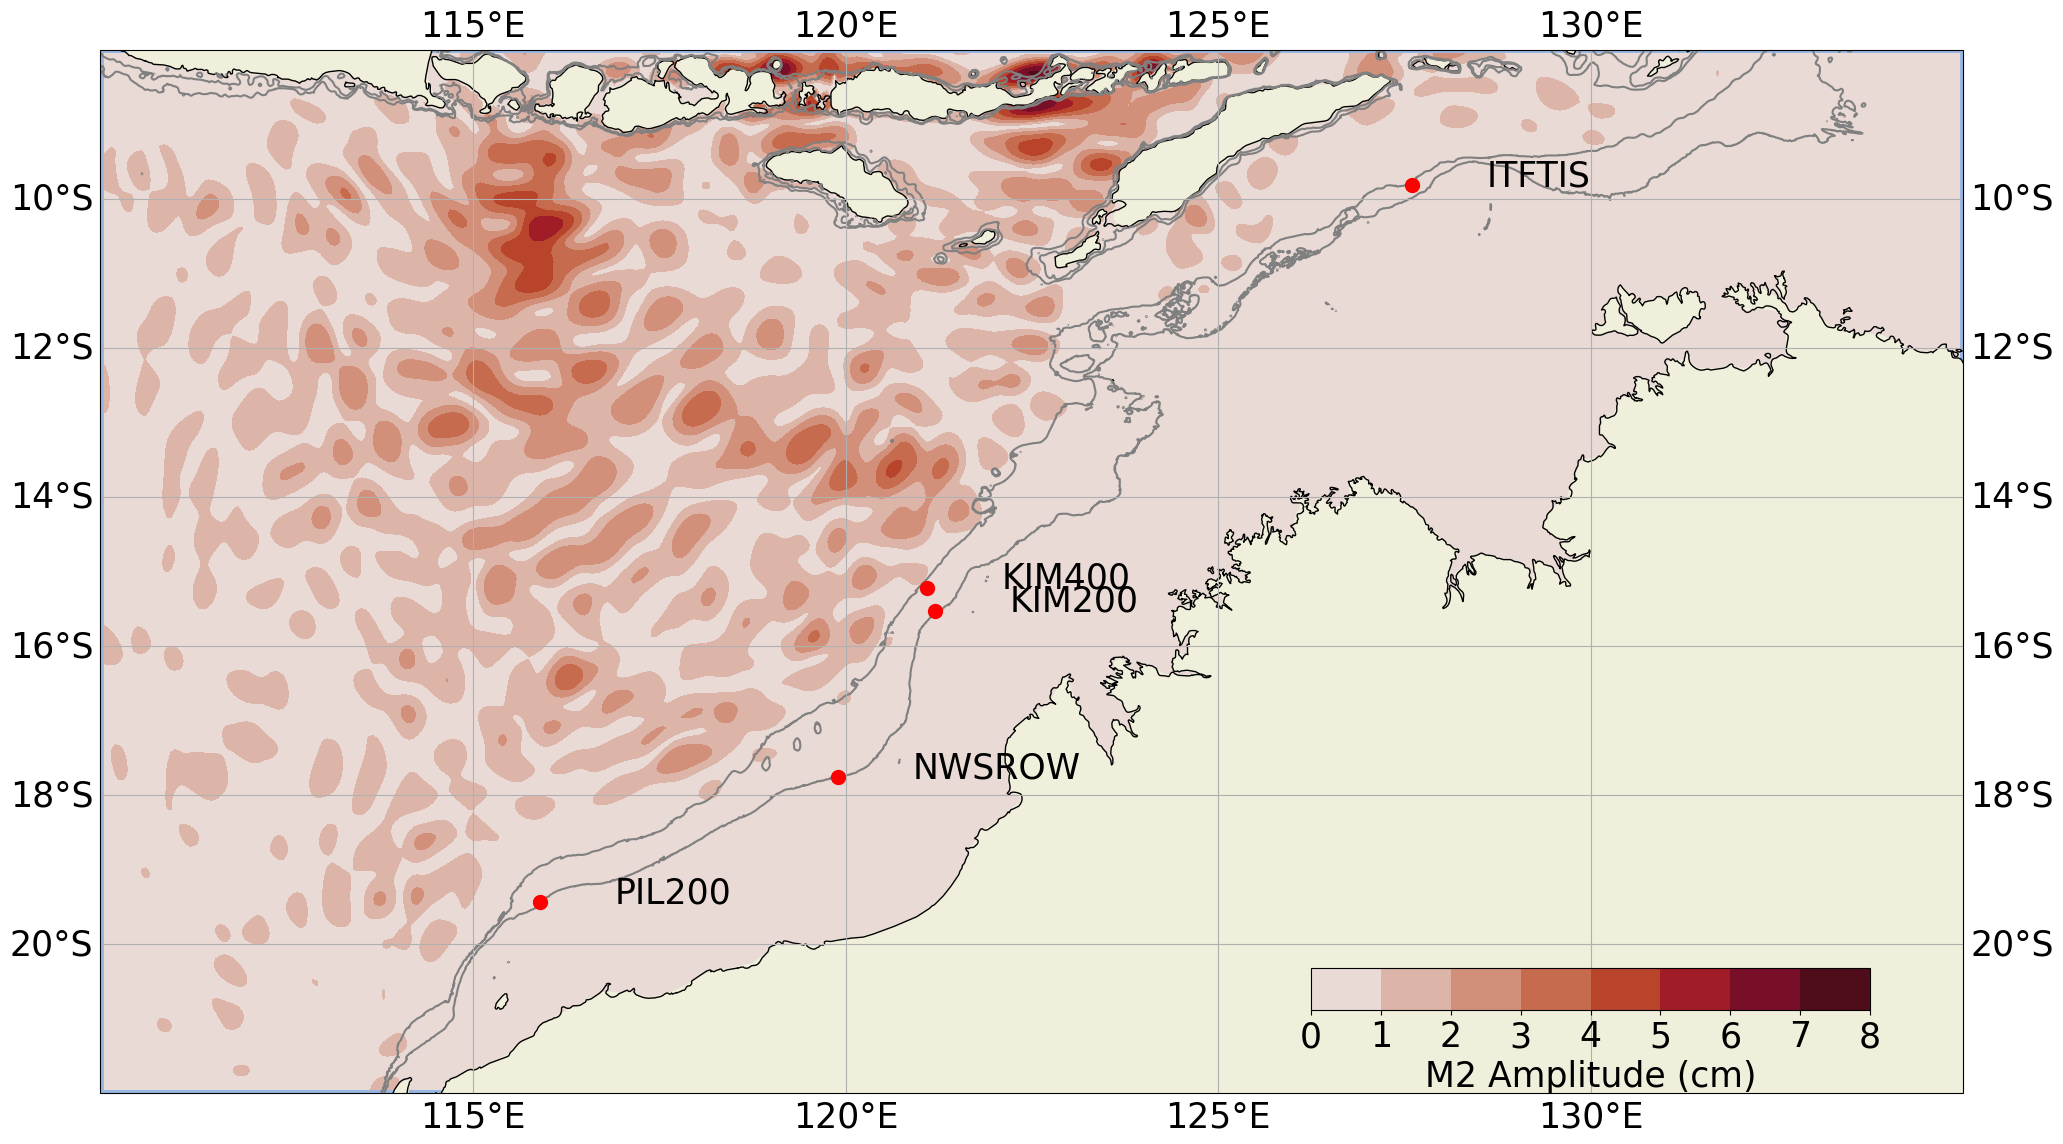

In [103]:
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['font.size'] = 25

# Location data
locations = {
    'KIM400': {'latitude': -15.22, 'longitude': 121.1},
    'PIL200': {'latitude': -19.44, 'longitude': 115.9},
    'KIM200': {'latitude': -15.53, 'longitude': 121.2},
    'ITFTIS': {'latitude': -9.817, 'longitude': 127.6},
    'NWSROW': {'latitude': -17.76, 'longitude': 119.9},
}

# Create a map using PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(25, 12))

# Specify the contour levels you want to display
contour_levels = [-500,-200]
# Plot contour lines for specified levels
contour_plot = plt.contour(X_bath, Y_bath, topo, levels=contour_levels,colors='gray',linestyles='solid')
# Add contour labels
# plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%1.0f',colors = 'black')    
    
# Plot the contour plot on top of the map
contour_plot = ax.contourf(X_SSH, Y_SSH, M2re*100, cmap='cmo.amp')
# Add colorbar inside the figure
cax = ax.inset_axes([0.65, 0.08, 0.3, 0.04])  # [left, bottom, width, height]
cbar = plt.colorbar(contour_plot, cax=cax,orientation='horizontal')
cbar.set_label('M2 Amplitude (cm)',fontsize=25)

# Set the extent of the map
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
# Add Natural Earth land and ocean features
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, zorder=1)
ax.add_feature(ocean, zorder=0)
# Add coastlines and gridlines
ax.coastlines()
# Use Cartopy's gridlines to control tick sizes
gridlines = ax.gridlines(draw_labels=True)
# Add markers and labels for specified locations
for location, data in locations.items():
    ax.plot(data['longitude'], data['latitude'], 'ro', markersize=10, transform=ccrs.PlateCarree())
    ax.text(data['longitude'] + 1, data['latitude'], location, transform=ccrs.PlateCarree(),fontsize=25)

ax.set_title('')
ax.grid(True)

# Adjust layout
fig.tight_layout()
#plt.savefig('mooring map.pdf')
# Show the map
plt.show()

In [104]:
# min_lat, max_lat = -45, -10
# min_lon, max_lon = 110, 155
# # Create a map using PlateCarree projection
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(5, 3))
# # Set the extent of the map
# ax.set_extent([min_lon, max_lon, min_lat, max_lat])
# # Add Natural Earth land and ocean features
# land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey')
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white')
# ax.add_feature(land, zorder=1)
# ax.add_feature(ocean, zorder=0)
# # Add coastlines and gridlines
# ax.coastlines()
# # Add markers and labels for specified locations
# ax.set_title('')
# ax.plot(121.2,-15.53, 'r*', markersize=30, transform=ccrs.PlateCarree())
# # Adjust layout
# fig.tight_layout()
# #plt.savefig('mooring map.pdf')
# # Show the map
# plt.show()

# Model fit plots Examples

In [108]:
Whole_Model_fit_Eg = [PIL200_Model_fit_Eg,KIM200_Model_fit_Eg,KIM400_Model_fit_Eg,ITFTIS_Model_fit_Eg,]
# Whole_Model_fit_Eg

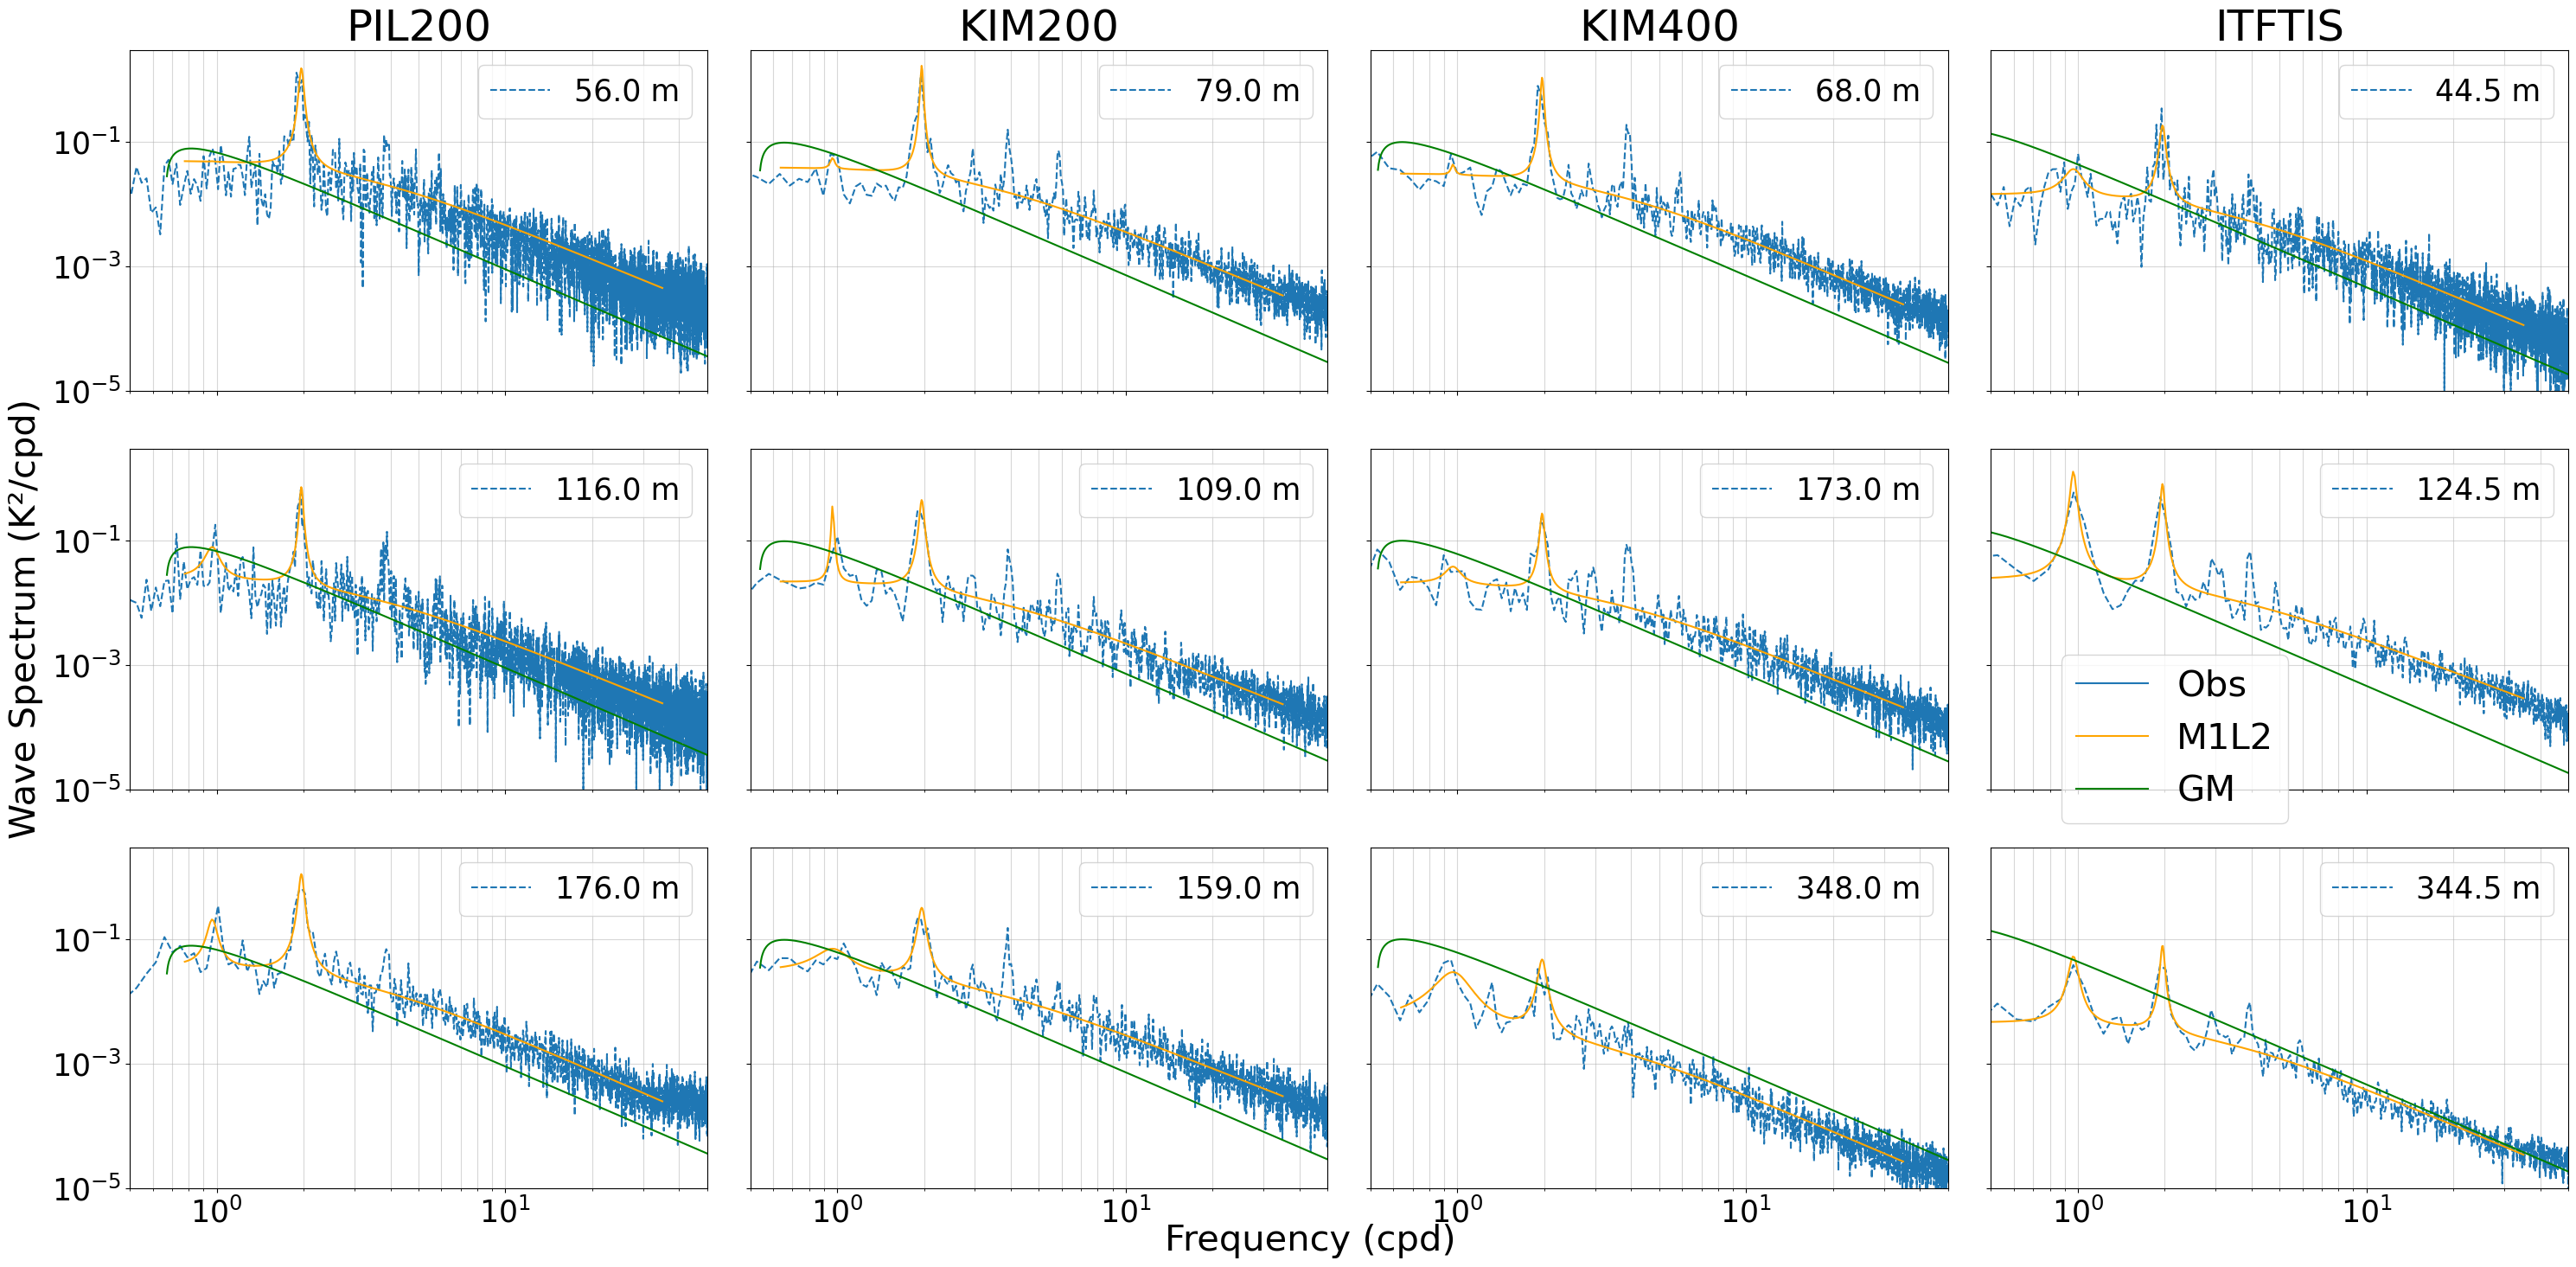

In [109]:
site_name = Whole_Soln_df_M1L2['site'].drop_duplicates()
rows = len(KIM400_Model_fit_Eg['Sorted_Depths'])
cols = len(Whole_Model_fit_Eg)
color_set  = ['tab:blue', 'orange', 'green'] 
line_type = ['Obs','M1L2','GM']
fig, axes = plt.subplots(rows, cols, figsize=(30, 15), sharex='col', sharey='row')
plt.rcParams['font.size'] = 30
for i, site in enumerate(Whole_Model_fit_Eg):
    for depth_order in range(len(site['Sorted_Depths'])):
        axes[depth_order,i].plot(site['F_obs'][depth_order],site['P_obs'][depth_order],label = '{} m'.format(site['Sorted_Depths'][depth_order]),linestyle='dashed',color='tab:blue')
        axes[depth_order,i].plot(site['F_model_fit'][depth_order],site['P_model_fit'][depth_order],color='orange')
        axes[depth_order,i].plot(site['F_gm'],site['P_gm'],color='green')
        axes[depth_order,i].set_xscale("log")
        axes[depth_order,i].set_yscale("log")
        axes[depth_order,i].set_ylim(1e-5, 3)
        axes[depth_order,i].set_xlim(0.5,50)
        axes[depth_order,i].legend(loc='upper right',fontsize=25)
        axes[depth_order,i].grid(True,which='both',alpha=0.5)
        if depth_order==0:
            axes[depth_order,i].set_title(site_name.iloc[i])
        
fig.text(0.5, 0.02, 'Frequency (cpd)', ha='center', va='center')
fig.text(0.005, 0.5, 'Wave Spectrum (K²/cpd)', ha='center', va='center', rotation='vertical')

# Create handles for the legend
handles = [plt.Line2D([0], [0], color=color_set[i], linestyle='-', label=line_type[i]) for i in range(len(color_set))]
# Place the legend
fig.legend(handles=handles, loc=(0.8,0.35),)  

# Adjust layout
fig.tight_layout()  # Adjust the rectangle to leave space for the y-axis label and legend
plt.savefig('model fit result at selected depths.pdf')
# Show the plot
plt.show()

# Pair plots 

In [114]:
# site = Whole_Soln_df_M1L2_clean['site'].drop_duplicates()
# selected_columns = ['η_matern1', 'η_peak1','η_peak2']
# for i in range(len(site)):
#     result_site = Whole_Soln_df_M1L2_clean[Whole_Soln_df_M1L2_clean['site']==site.iloc[i]]
#     sns.pairplot(result_site[selected_columns])

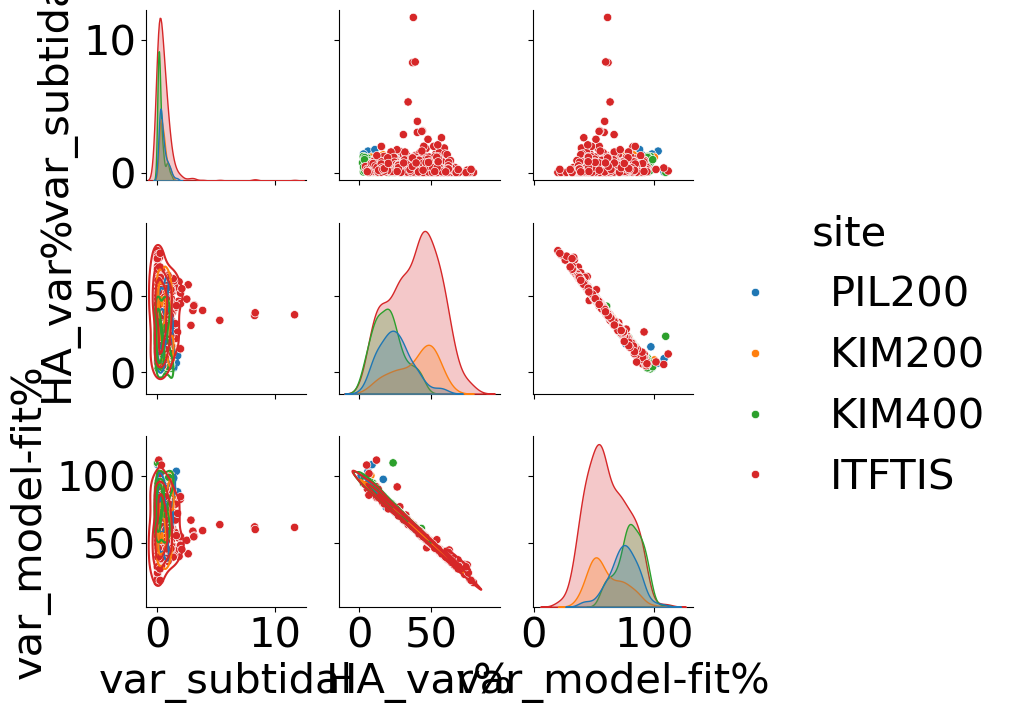

In [115]:
selected_columns = ['site','var_subtidal','HA_var%','var_model-fit%',]
# colors = ['blue', 'orange', 'darkcyan','red'] 
pair_plot_df = Whole_Soln_df_M1L2_clean[selected_columns].reset_index(drop=True)
g = sns.pairplot(pair_plot_df, diag_kind="kde", hue="site",)
g.map_lower(sns.kdeplot, levels=4, color=".2")
#plt.savefig('whoel pair plot.pdf')
# Show the plot
plt.show()

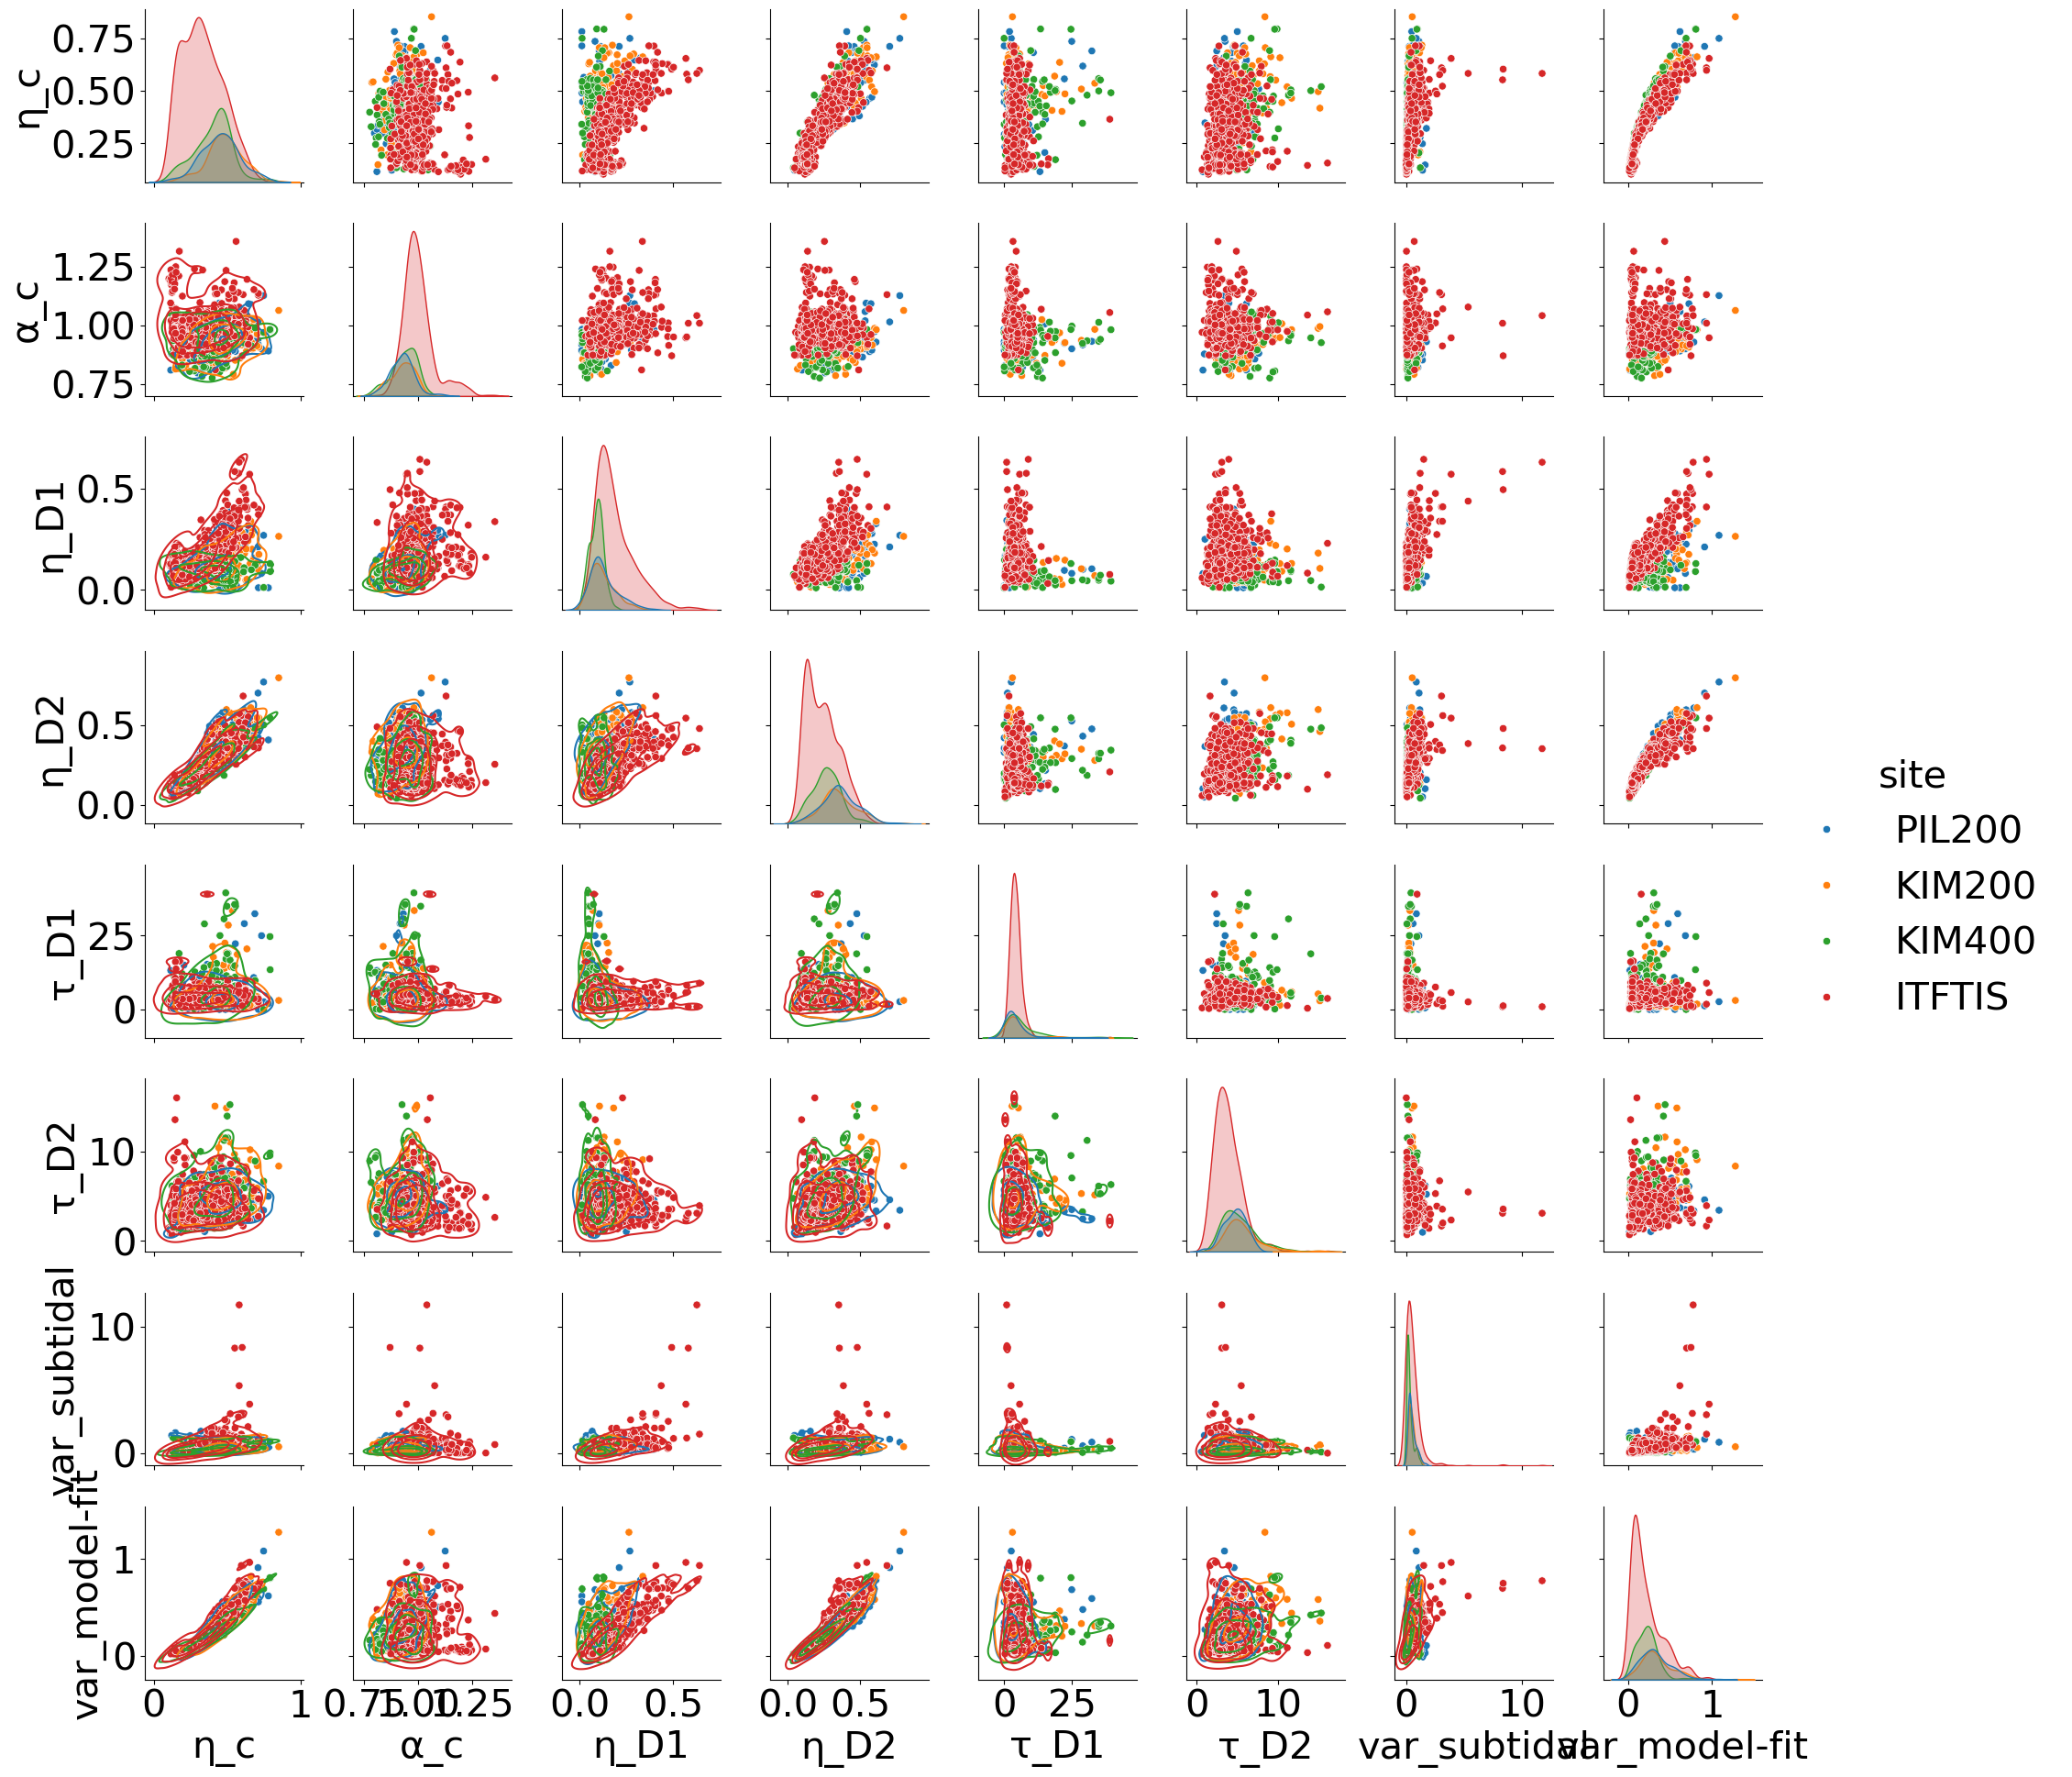

In [116]:
selected_columns = ['site','η_c','α_c','η_D1','η_D2','τ_D1','τ_D2','var_subtidal','var_model-fit']
# colors = ['blue', 'orange', 'darkcyan','red'] 
pair_plot_df = Whole_Soln_df_M1L2_clean[selected_columns].reset_index(drop=True)
g = sns.pairplot(pair_plot_df, diag_kind="kde", hue="site")#, markers=['o', 's', '^', 'v'], palette=colors)
g.map_lower(sns.kdeplot, levels=4, color=".2")
#plt.savefig('whoel pair plot.pdf')
# Show the plot
plt.show()

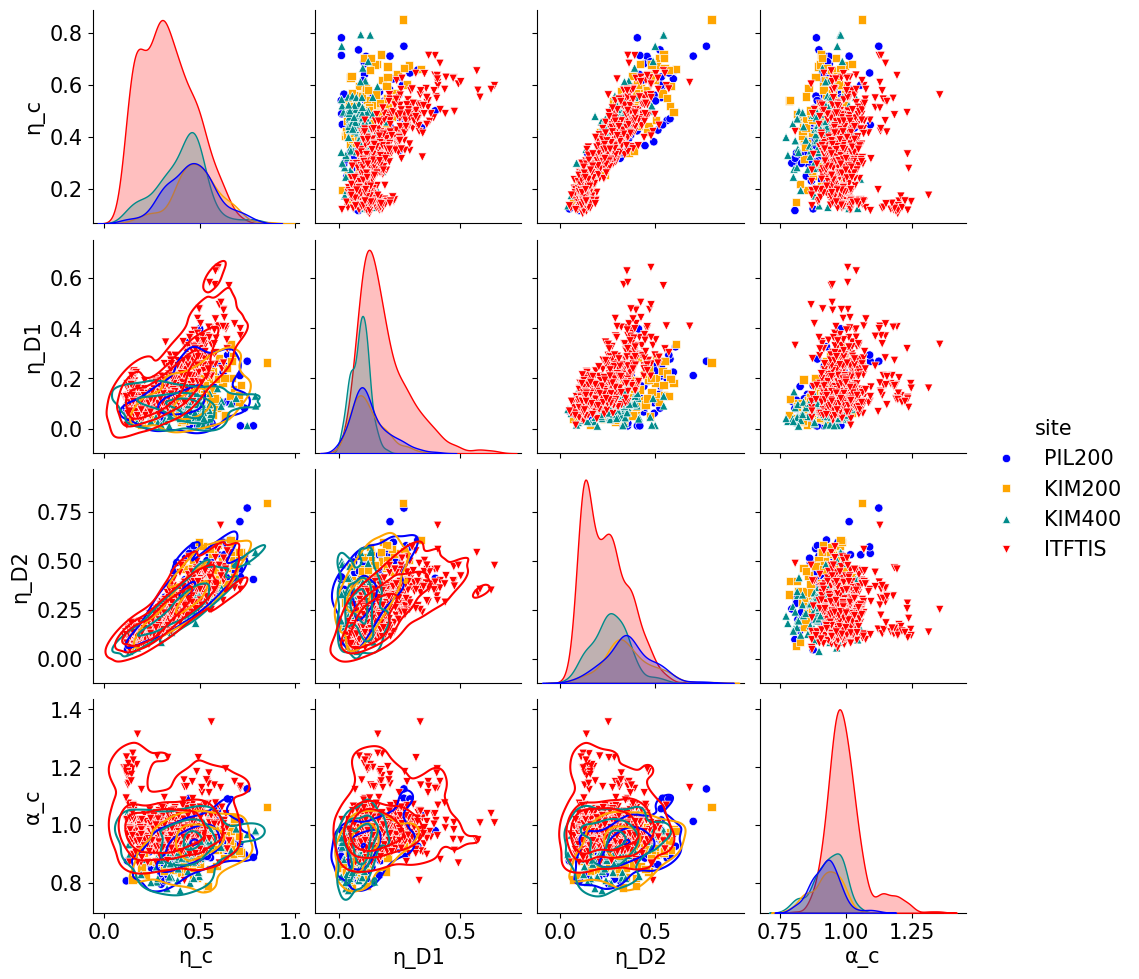

In [205]:
plt.rcParams['font.size'] = 15
selected_columns = ['site','η_c','η_D1','η_D2','α_c']
colors = ['blue', 'orange', 'darkcyan','red'] 
pair_plot_df = Whole_Soln_df_M1L2_clean[selected_columns].reset_index(drop=True)
g = sns.pairplot(pair_plot_df, diag_kind="kde", hue="site", markers=['o', 's', '^', 'v'], palette=colors)
g.map_lower(sns.kdeplot, levels=4, color=".2")
    
plt.savefig('whoel pair plot.pdf')
# Show the plot
plt.show()

# Parameter and Var medium and sd

In [266]:
#order is changed
for parameter_name in [
    'η_c',
    'α_c',
    'η_D1',
    'τ_D1',
    'η_D2',
    'τ_D2',
    'HA_var%',
    'var_model-fit_NPL%',]: 
    # marker - stie
    parameters_values = Whole_Soln_df_M1L2_clean [(Whole_Soln_df_M1L2_clean ['site'] == 'KIM400')]['{}'.format(parameter_name)]
    clean_data = [x for x in parameters_values if not np.isnan(x)]
        
    # Calculate the 50th percentile (median)
    median = np.percentile(clean_data, 50)
    sd = np.std(clean_data)
    print("50th percentile (median): {} ({})".format(np.round(median,2),np.round(sd,2)))

#     # Calculate the 90th percentile
#     percentile_90 = np.percentile(clean_data, 90)
#     print("90th percentile:", np.round(percentile_90,4))
    
#     sd = np.std(clean_data)
#     print('std is',np.round(sd,2))

50th percentile (median): 0.43 (0.13)
50th percentile (median): 0.94 (0.06)
50th percentile (median): 0.09 (0.04)
50th percentile (median): 3.91 (7.34)
50th percentile (median): 0.26 (0.1)
50th percentile (median): 4.88 (2.25)
50th percentile (median): 19.64 (10.51)
50th percentile (median): 99.72 (3.85)


In [209]:
median_list = []
for parameter_name in [
    'var_subset',
    'HA_var',
    'var_modulated',
    'var_model-fit']: 
    # marker - stie
    parameters_values = Whole_Soln_df_M1L2_clean [(Whole_Soln_df_M1L2_clean ['site'] == 'PIL200')]['{}'.format(parameter_name)]
    clean_data = [x for x in parameters_values if not np.isnan(x)]
        
    # Calculate the 50th percentile (median)
    median = np.percentile(clean_data, 50)
    sd = np.std(clean_data)
    median_list.append(median)
    
for i in median_list[:3]:
    print("50th percentile (median): {} ({})".format(np.round(i,3),np.round(i/median_list[0]*100,2)))

50th percentile (median): 0.41 (100.0)
50th percentile (median): 0.097 (23.57)
50th percentile (median): 0.307 (74.82)


<!-- ## Box plot -->

# Stratification

In [212]:
def find_max_η_depth(data,lat,threshold):
    '''
    data: from Whole_Soln_df_M1L2_clean with selected site and season
    '''
    N2_list = []
    p_mid_list = []    
    for year in data['year'].unique():
#     for year in [2012]:    
            b = data[data['year']==year].sort_values(by='depth_round').copy()
            p = gsw.conversions.p_from_z(b['depth_round'].unique(),lat)
            SA = np.array([34.6]*len(p))
            CT = gsw.conversions.CT_from_t(SA,b['mean_temp'],p)
            N2,p_mid = gsw.stability.Nsquared(SA,CT,p,lat)

            N2_list.append(N2)
            p_mid_list.append(p_mid)
            CT_list.append(CT)
            p_list.append(p)
         
    p_mid = np.concatenate(p_mid_list)
    N2 = np.concatenate(N2_list) 
    #df_N2
    data ={'N2':N2,'p_mid':p_mid}
    df = pd.DataFrame(data).sort_values(by='p_mid')
    n2_mean = df.groupby('p_mid')['N2'].mean().reset_index()
    #find the idx for max
    max_index = n2_mean['N2'].idxmax()
    max_value_depth_up   = gsw.conversions.z_from_p(n2_mean.loc[max_index, 'p_mid'],lat)+threshold
    max_value_depth_down = gsw.conversions.z_from_p(n2_mean.loc[max_index, 'p_mid'],lat)-threshold
        
    return max_value_depth_up, max_value_depth_down

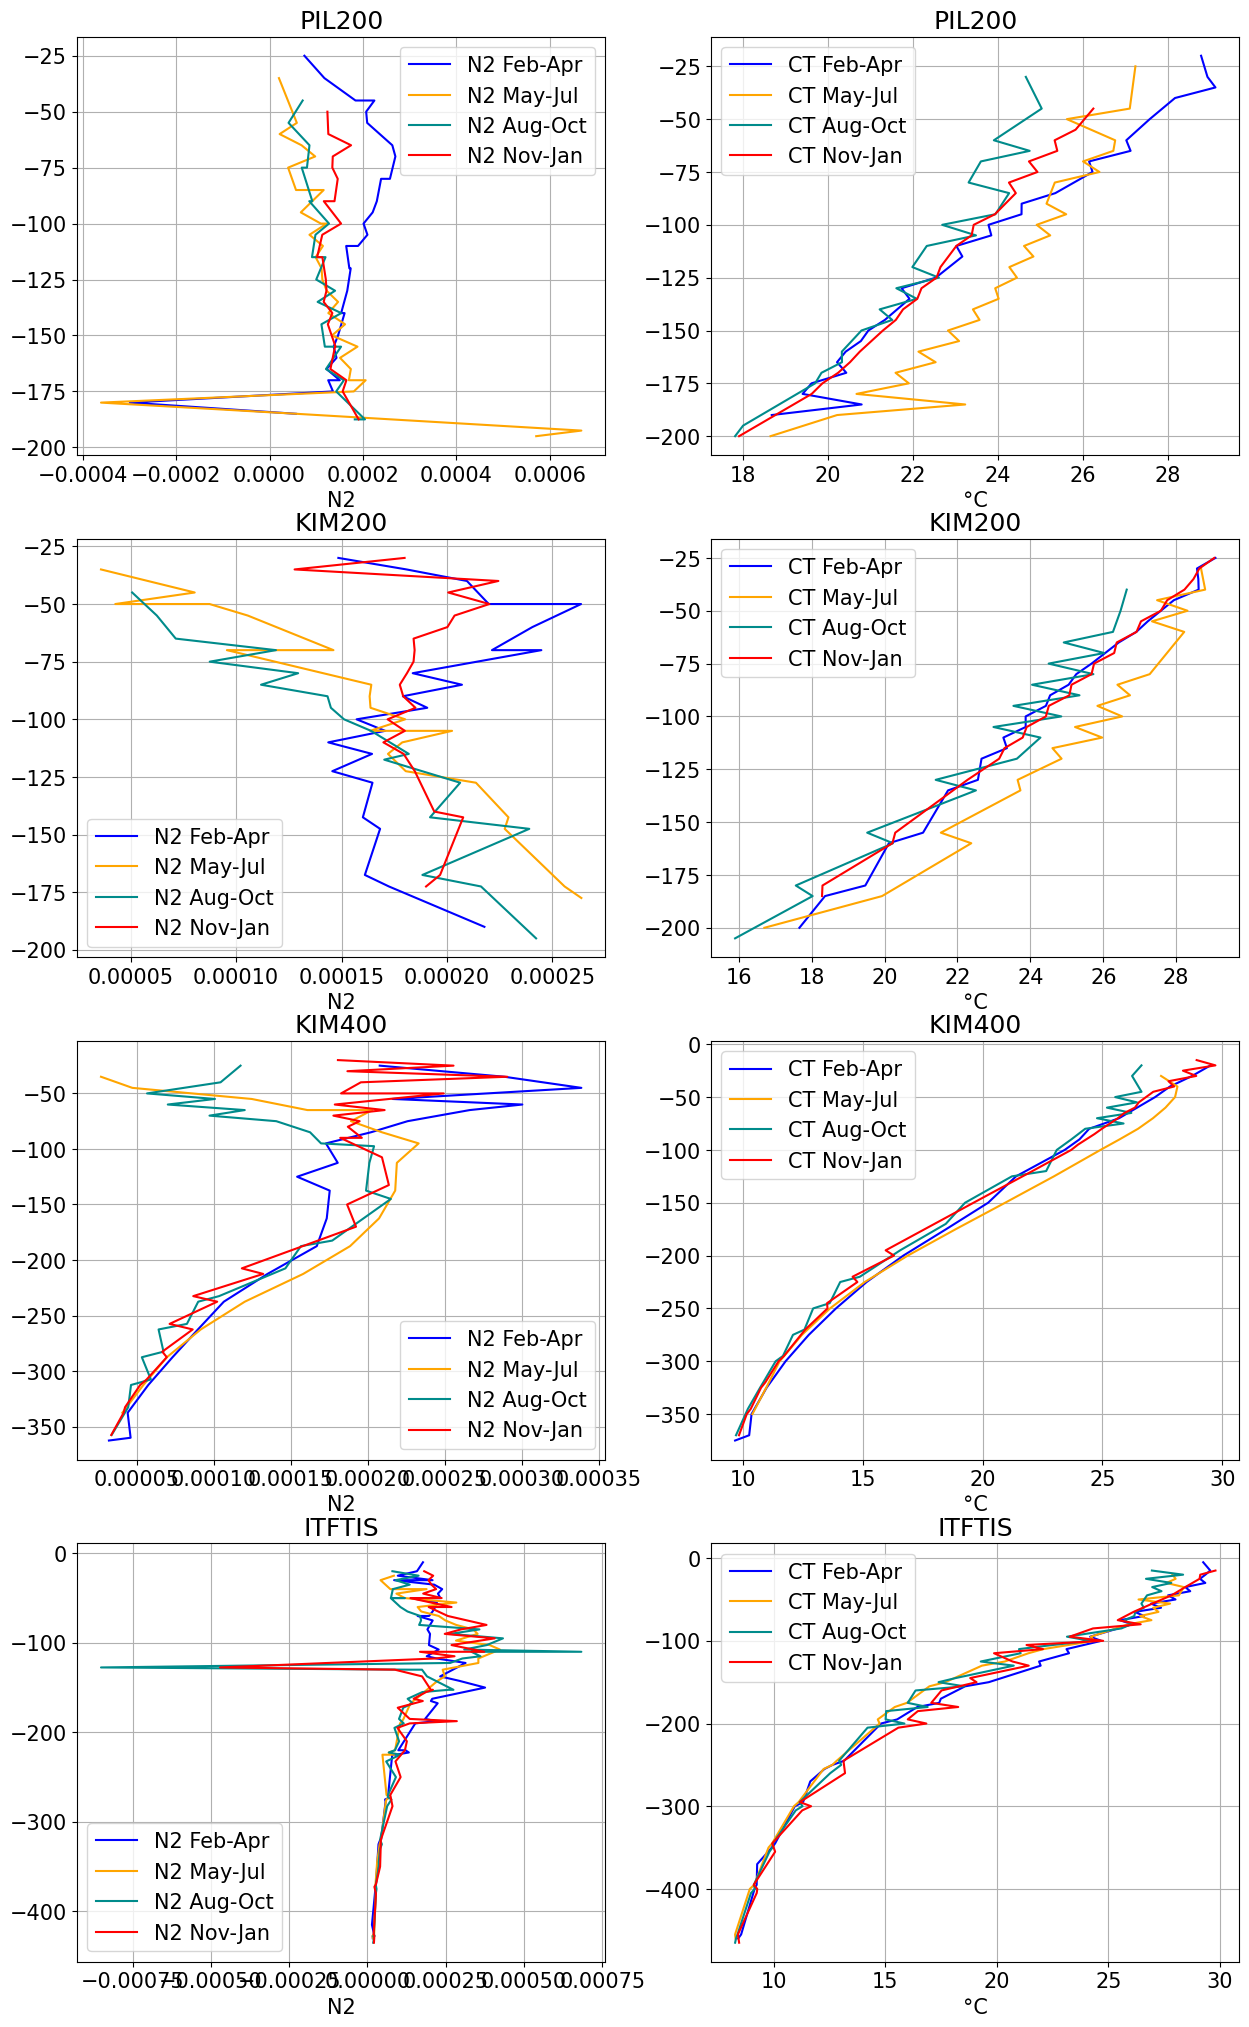

In [213]:
locations = ['PIL200','KIM200','KIM400','ITFTIS']
lat_list = [-19.44,-15.53,-15.22,-9.817,]
seasons = Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
colors = ['blue','orange', 'darkcyan','red','black'] 

# Plot box plot
cols = 2
rows = len(locations)

fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
axes = axes.flatten()
plt.rcParams['font.size'] = 15
for order1,loc in enumerate(locations):
    for order2,season in enumerate(seasons):
        N2_list = []
        p_mid_list = []    
        CT_list = []
        p_list = []
        a = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] == loc)&(Whole_Soln_df_M1L2_clean['season'] == season)].copy()
        for year in a['year'].unique():
            b = a[a['year']==year].sort_values(by='depth_round')
            lat = lat_list[order1]
            p = gsw.conversions.p_from_z(b['depth_round'].unique(),lat)
            SA = np.array([34.6]*len(p))
            CT = gsw.conversions.CT_from_t(SA,b['mean_temp'],p)
            N2,p_mid = gsw.stability.Nsquared(SA,CT,p,lat)

            N2_list.append(N2)
            p_mid_list.append(p_mid)
            CT_list.append(CT)
            p_list.append(p)
            
        p_mid = np.concatenate(p_mid_list)
        N2 = np.concatenate(N2_list)
        p_CT = np.concatenate(p_list)
        CT = np.concatenate(CT_list)
        
        #data_N2
        data ={'N2':N2,'p_mid':p_mid}
        df = pd.DataFrame(data).sort_values(by='p_mid')
        n2_mean = df.groupby('p_mid')['N2'].mean().reset_index()
        n2_mean_depth = gsw.conversions.z_from_p(n2_mean['p_mid'],lat)
        #data_CT
        data_CT ={'CT':CT,'p_CT':p_CT}
        df = pd.DataFrame(data_CT).sort_values(by='p_CT')
        CT_mean = df.groupby('p_CT')['CT'].mean().reset_index()
        CT_mean_depth = gsw.conversions.z_from_p(CT_mean['p_CT'],lat)
        #smooth
        window_size = 3  # Adjust window size as needed
        smoothed_values = n2_mean['N2'].rolling(window=window_size).mean()
        #PLOT
        axes[order1*2].plot(n2_mean['N2'], n2_mean_depth,color=colors[order2],label='N2 {}'.format(season))
        axes[order1*2+1].plot(CT_mean['CT'], CT_mean_depth,color=colors[order2],label='CT {}'.format(season))
#         axes[order].plot(smoothed_values, n2_mean_depth,label='smooth {}'.format(season))
        axes[order1*2].set_title(loc)
        axes[order1*2+1].set_title(loc)
        
        axes[order1*2].set_xlabel('N2')
        axes[order1*2+1].set_xlabel('°C')
        
for axe in axes:
    axe.grid(True)
    axe.legend()    
#     plt.plot(p,CT)
#     plt.legend()
#     plt.xlabel('N2')
#     plt.ylabel('depth')
#     plt.title(loc)

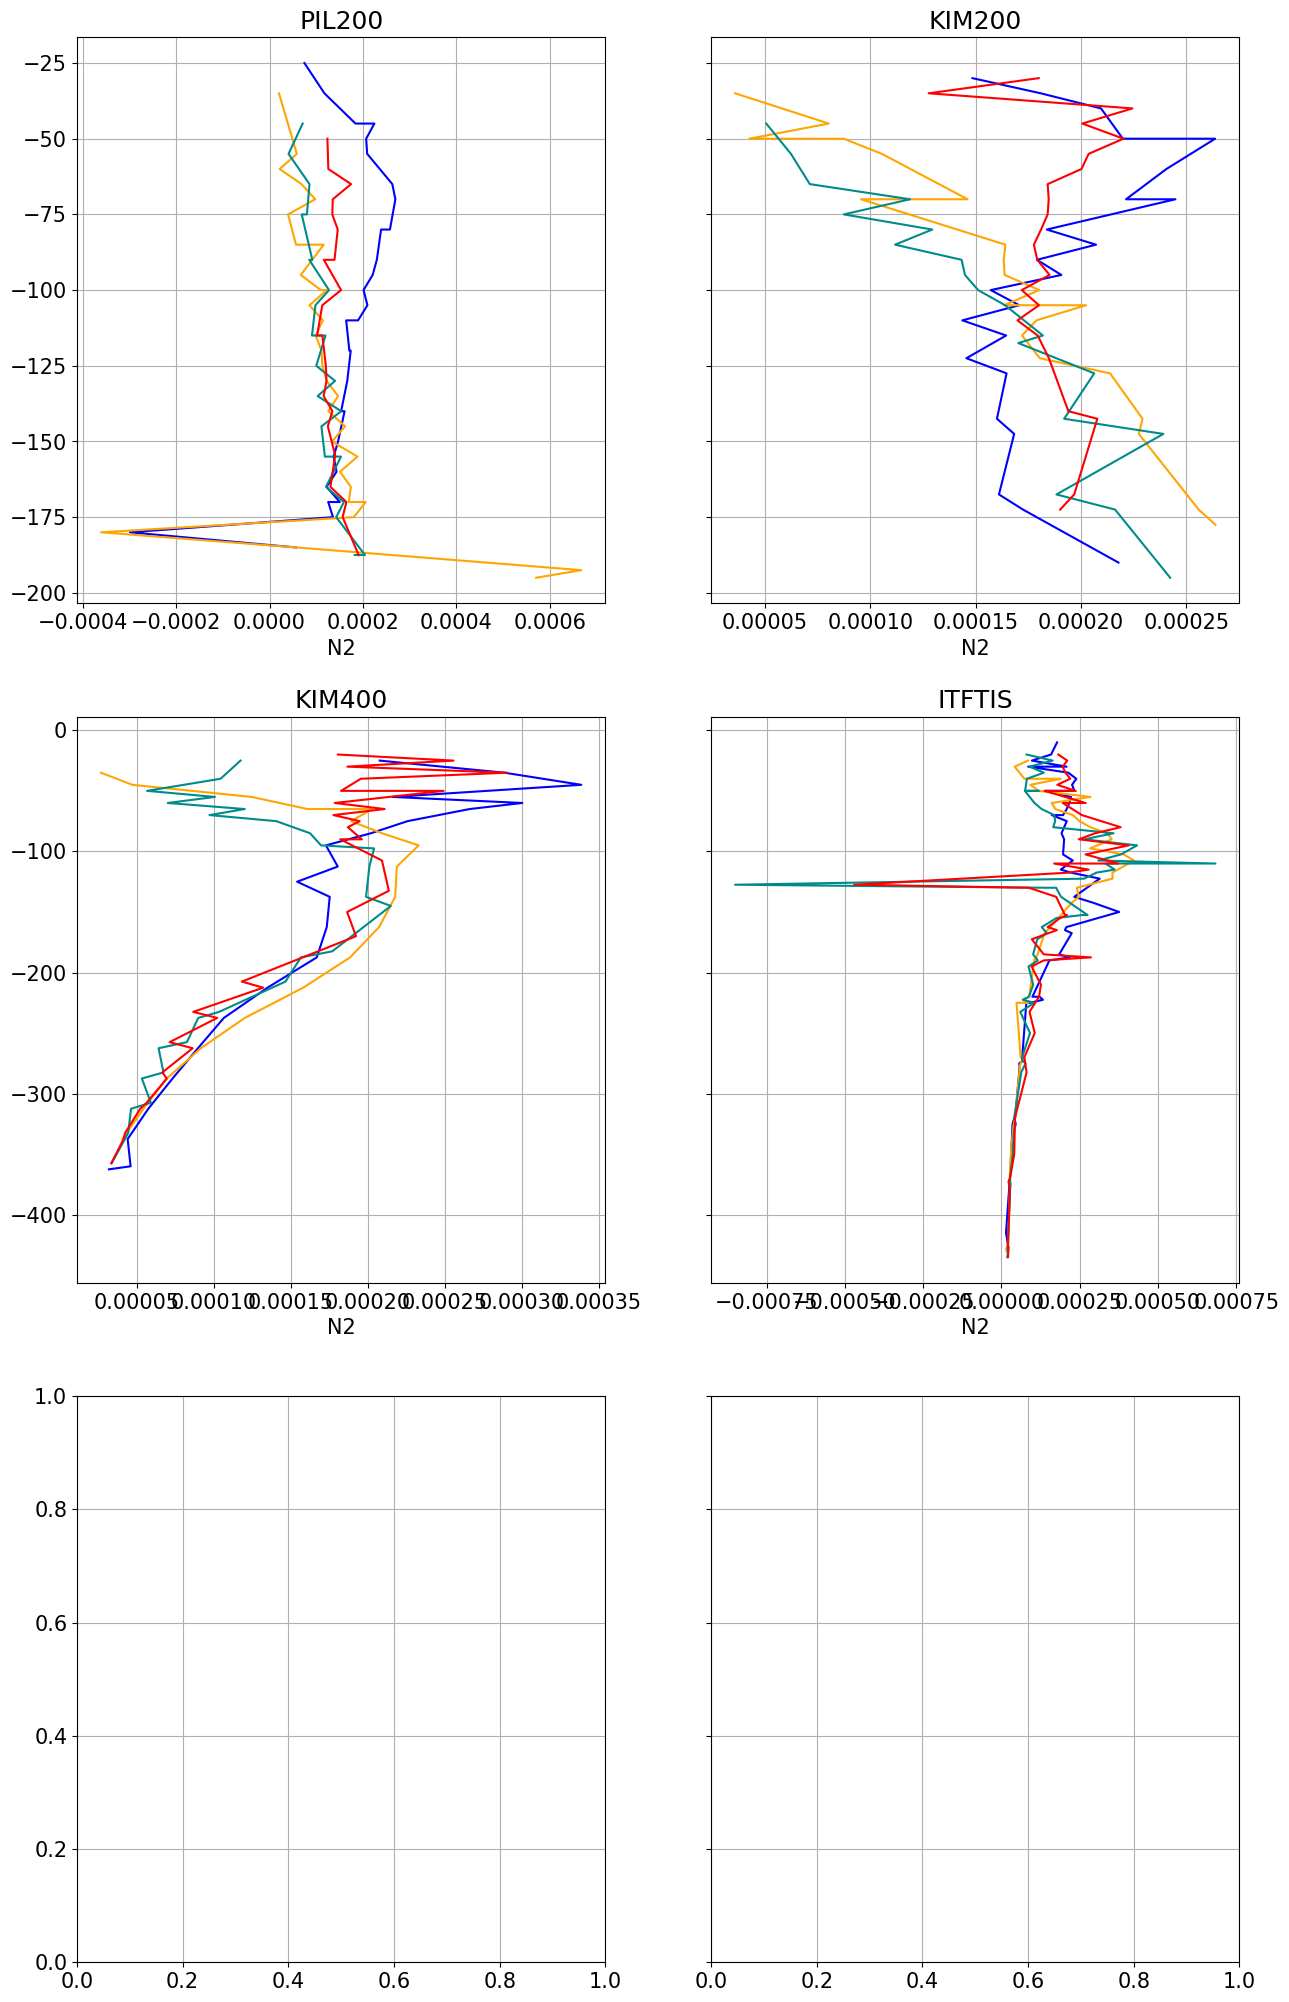

In [216]:
locations = ['PIL200','KIM200','KIM400','ITFTIS']
lat_list = [-19.44,-15.53,-15.22,-9.817,]
seasons = Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
colors = ['blue','orange', 'darkcyan','red'] 

# Plot box plot
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 25),sharey='row')
axes = axes.flatten()
plt.rcParams['font.size'] = 15
for order1,loc in enumerate(locations):
    for order2,season in enumerate(seasons):
        N2_list = []
        p_mid_list = []    
        CT_list = []
        p_list = []
        a = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] == loc)&(Whole_Soln_df_M1L2_clean['season'] == season)].copy()
        for year in a['year'].unique():
            b = a[a['year']==year].sort_values(by='depth_round')
            lat = lat_list[order1]
            p = gsw.conversions.p_from_z(b['depth_round'].unique(),lat)
            SA = np.array([34.6]*len(p))
            CT = gsw.conversions.CT_from_t(SA,b['mean_temp'],p)
            N2,p_mid = gsw.stability.Nsquared(SA,CT,p,lat)

            N2_list.append(N2)
            p_mid_list.append(p_mid)
            CT_list.append(CT)
            p_list.append(p)
            
        p_mid = np.concatenate(p_mid_list)
        N2 = np.concatenate(N2_list)
        p_CT = np.concatenate(p_list)
        CT = np.concatenate(CT_list)
        
        #data_N2
        data ={'N2':N2,'p_mid':p_mid}
        df = pd.DataFrame(data).sort_values(by='p_mid')
        n2_mean = df.groupby('p_mid')['N2'].mean().reset_index()
        n2_mean_depth = gsw.conversions.z_from_p(n2_mean['p_mid'],lat)
       
        #smooth
        window_size = 3  # Adjust window size as needed
        smoothed_values = n2_mean['N2'].rolling(window=window_size).mean()
        #PLOT
        axes[order1].plot(n2_mean['N2'], n2_mean_depth,color=colors[order2],label='N2 {}'.format(season))
#         axes[order].plot(smoothed_values, n2_mean_depth,label='smooth {}'.format(season))
        axes[order1].set_title(loc)
        axes[order1].set_xlabel('N2')

        
for axe in axes:
    axe.grid(True)
#     axe.legend()    


In [217]:
threshold = 40 #m
for i, loc in enumerate(locations):
    for j, season in enumerate(seasons):
        data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
        #find the depth of max η_c
        max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
        thermocline_depth = (max_value_depth_up+max_value_depth_down)/2
        print(loc,season,thermocline_depth)

PIL200 Feb-Apr -70.0000609948858
PIL200 May-Jul -192.5001368803257
PIL200 Aug-Oct -187.5001368949438
PIL200 Nov-Jan -187.5003802637316
KIM200 Feb-Apr -50.00024403552291
KIM200 May-Jul -177.50123207607155
KIM200 Aug-Oct -195.00024328213428
KIM200 Nov-Jan -40.00006102187132
KIM400 Feb-Apr -45.00006101452689
KIM400 May-Jul -95.00006094957794
KIM400 Aug-Oct -145.0015221157803
KIM400 Nov-Jan -35.00006102751706
ITFTIS Feb-Apr -150.00097385544106
ITFTIS May-Jul -107.5001370725777
ITFTIS Aug-Oct -110.00006091789976
ITFTIS Nov-Jan -95.00024374950186


In [218]:
# locations = ['PIL200','KIM200','KIM400','ITFTIS']
# lat_list = [-19.44, -15.53,-15.22,-9.817,]
# seasons = Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
# colors = ['tab:blue', 'orange', 'green','red'] 

# # Plot box plot
# cols = 2
# rows = 4

# fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
# axes = axes.flatten()
# plt.rcParams['font.size'] = 15

# for order1,loc in enumerate(locations):
#     for order2,season in enumerate(seasons):
#         N2_list = []
#         p_mid_list = []    
#         CT_list = []
#         p_list = []
#         a = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] == loc)&(Whole_Soln_df_M1L2_clean['season'] == season)].copy()
#         for year in [2019]:
#             b = a[a['year']==year].sort_values(by='depth_round')
#             lat = lat_list[order1]
#             p = gsw.conversions.p_from_z(b['depth_round'].unique(),lat)
#             SA = np.array([34.6]*len(p))
#             CT = gsw.conversions.CT_from_t(SA,b['mean_temp'],p)
#             N2,p_mid = gsw.stability.Nsquared(SA,CT,p,lat)

#             N2_list.append(N2)
#             p_mid_list.append(p_mid)
#             CT_list.append(CT)
#             p_list.append(p)
            
#         p_mid = np.concatenate(p_mid_list)
#         N2 = np.concatenate(N2_list)
#         N2 = np.sqrt(N2)
#         p_CT = np.concatenate(p_list)
#         CT = np.concatenate(CT_list)
        
#         #data_N2
#         data ={'N2':N2,'p_mid':p_mid}
#         df = pd.DataFrame(data).sort_values(by='p_mid')
#         n2_mean = df.groupby('p_mid')['N2'].mean().reset_index()
#         n2_mean_depth = gsw.conversions.z_from_p(n2_mean['p_mid'],lat)
#         #data_CT
#         data_CT ={'CT':CT,'p_CT':p_CT}
#         df = pd.DataFrame(data_CT).sort_values(by='p_CT')
#         CT_mean = df.groupby('p_CT')['CT'].mean().reset_index()
#         CT_mean_depth = gsw.conversions.z_from_p(CT_mean['p_CT'],lat)
#         #smooth
#         window_size = 3  # Adjust window size as needed
#         smoothed_values = n2_mean['N2'].rolling(window=window_size).mean()
#         #PLOT
#         axes[order1*2].plot(n2_mean['N2'], n2_mean_depth,color=colors[order2],label='N2 {}'.format(season))
#         axes[order1*2+1].plot(CT_mean['CT'], CT_mean_depth,color=colors[order2],label='CT {}'.format(season))
# #         axes[order].plot(smoothed_values, n2_mean_depth,label='smooth {}'.format(season))
#         axes[order1*2].set_title(loc)
#         axes[order1*2+1].set_title(loc)
        
#         axes[order1*2].set_xlabel('N2')
#         axes[order1*2+1].set_xlabel('°C')
        
# for axe in axes:
#     axe.grid(True)
#     axe.legend()    
# #     plt.plot(p,CT)
# #     plt.legend()
# #     plt.xlabel('N2')
# #     plt.ylabel('depth')
# #     plt.title(loc)

# box plots for individual location

In [306]:
threshold = 40 #m
locations = ['PIL200','KIM200','KIM400','ITFTIS']
lat_list = [-19.44, -15.53,-15.22,-9.817,]
thermocline_depth_list = []
for i, loc in enumerate(locations):
    depth_list = []
    for j, season in enumerate(seasons):
        data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
        #find the depth of max η_c
        max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
        thermocline_depth = (max_value_depth_up+max_value_depth_down)/2
        depth_list.append(thermocline_depth)
    thermocline_depth_list.append(np.average(depth_list))
thermocline_depth_list

[-159.37517875847172,
 -115.62544510390002,
 -80.00042627685055,
 -115.6253538988551]

In [308]:
def Find_avg_thermocline_depth(dataset,loc,lat,seasons,threshold=40):
    depth_list=[]
    for j, season in enumerate(seasons):
        data = dataset.loc[(dataset['site'] =='{}'.format(loc)) & (dataset['season'] =='{}'.format(season))].copy()
        #find the depth of max η_c
        max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat,threshold)
        thermocline_depth = (max_value_depth_up+max_value_depth_down)/2
        depth_list.append(thermocline_depth)
    
    return np.average(depth_list)

In [310]:
KIM400_avg_thermocline_depth1 = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,'KIM400',-15.53,['May-Jul','Aug-Oct'],threshold=10)
KIM400_avg_thermocline_depth2 = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,'KIM400',-15.53,['Feb-Apr','Nov-Jan'],threshold=10)
KIM400_avg_thermocline_depth1,KIM400_avg_thermocline_depth2 

(-120.00079154366958, -40.000061021871346)

In [312]:
for i,loc in enumerate(locations):
    for season in[['May-Jul','Aug-Oct'],['Feb-Apr','Nov-Jan']]:
        avg_thermocline_depth = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,loc,lat_list[i],season,threshold=10)
        print(loc,avg_thermocline_depth)

PIL200 -190.00013688763477
PIL200 -128.7502206293087
KIM200 -186.2507376791029
KIM200 -45.000152528697114
KIM400 -120.00079153267912
KIM400 -40.000061021021985
ITFTIS -108.75009899523874
ITFTIS -122.50060880247145


## Deep

In [225]:
def Estimate_position(target_depth,depth_list):
    '''
    estimate the position of a specific depth in the depth list
    '''
    # Find the two depths in depth_list that are closest to the target depth
    depth_array = np.array(depth_list)
    if target_depth < depth_array.min() or target_depth > depth_array.max():
        raise ValueError(f"Target depth {target_depth} is out of the range of depth_list")
        
    # Find the indices of the two closest depths
    lower_index = np.searchsorted(depth_array, target_depth) - 1
    upper_index = lower_index + 1
    
    lower_depth = depth_array[lower_index]
    upper_depth = depth_array[upper_index]
    
    # Interpolate the position of the target depth
    interpolated_position = lower_index + (target_depth - lower_depth) / (upper_depth - lower_depth)
    
    return interpolated_position

KIM400 -80.00042627685055
ITFTIS -115.6253538988551


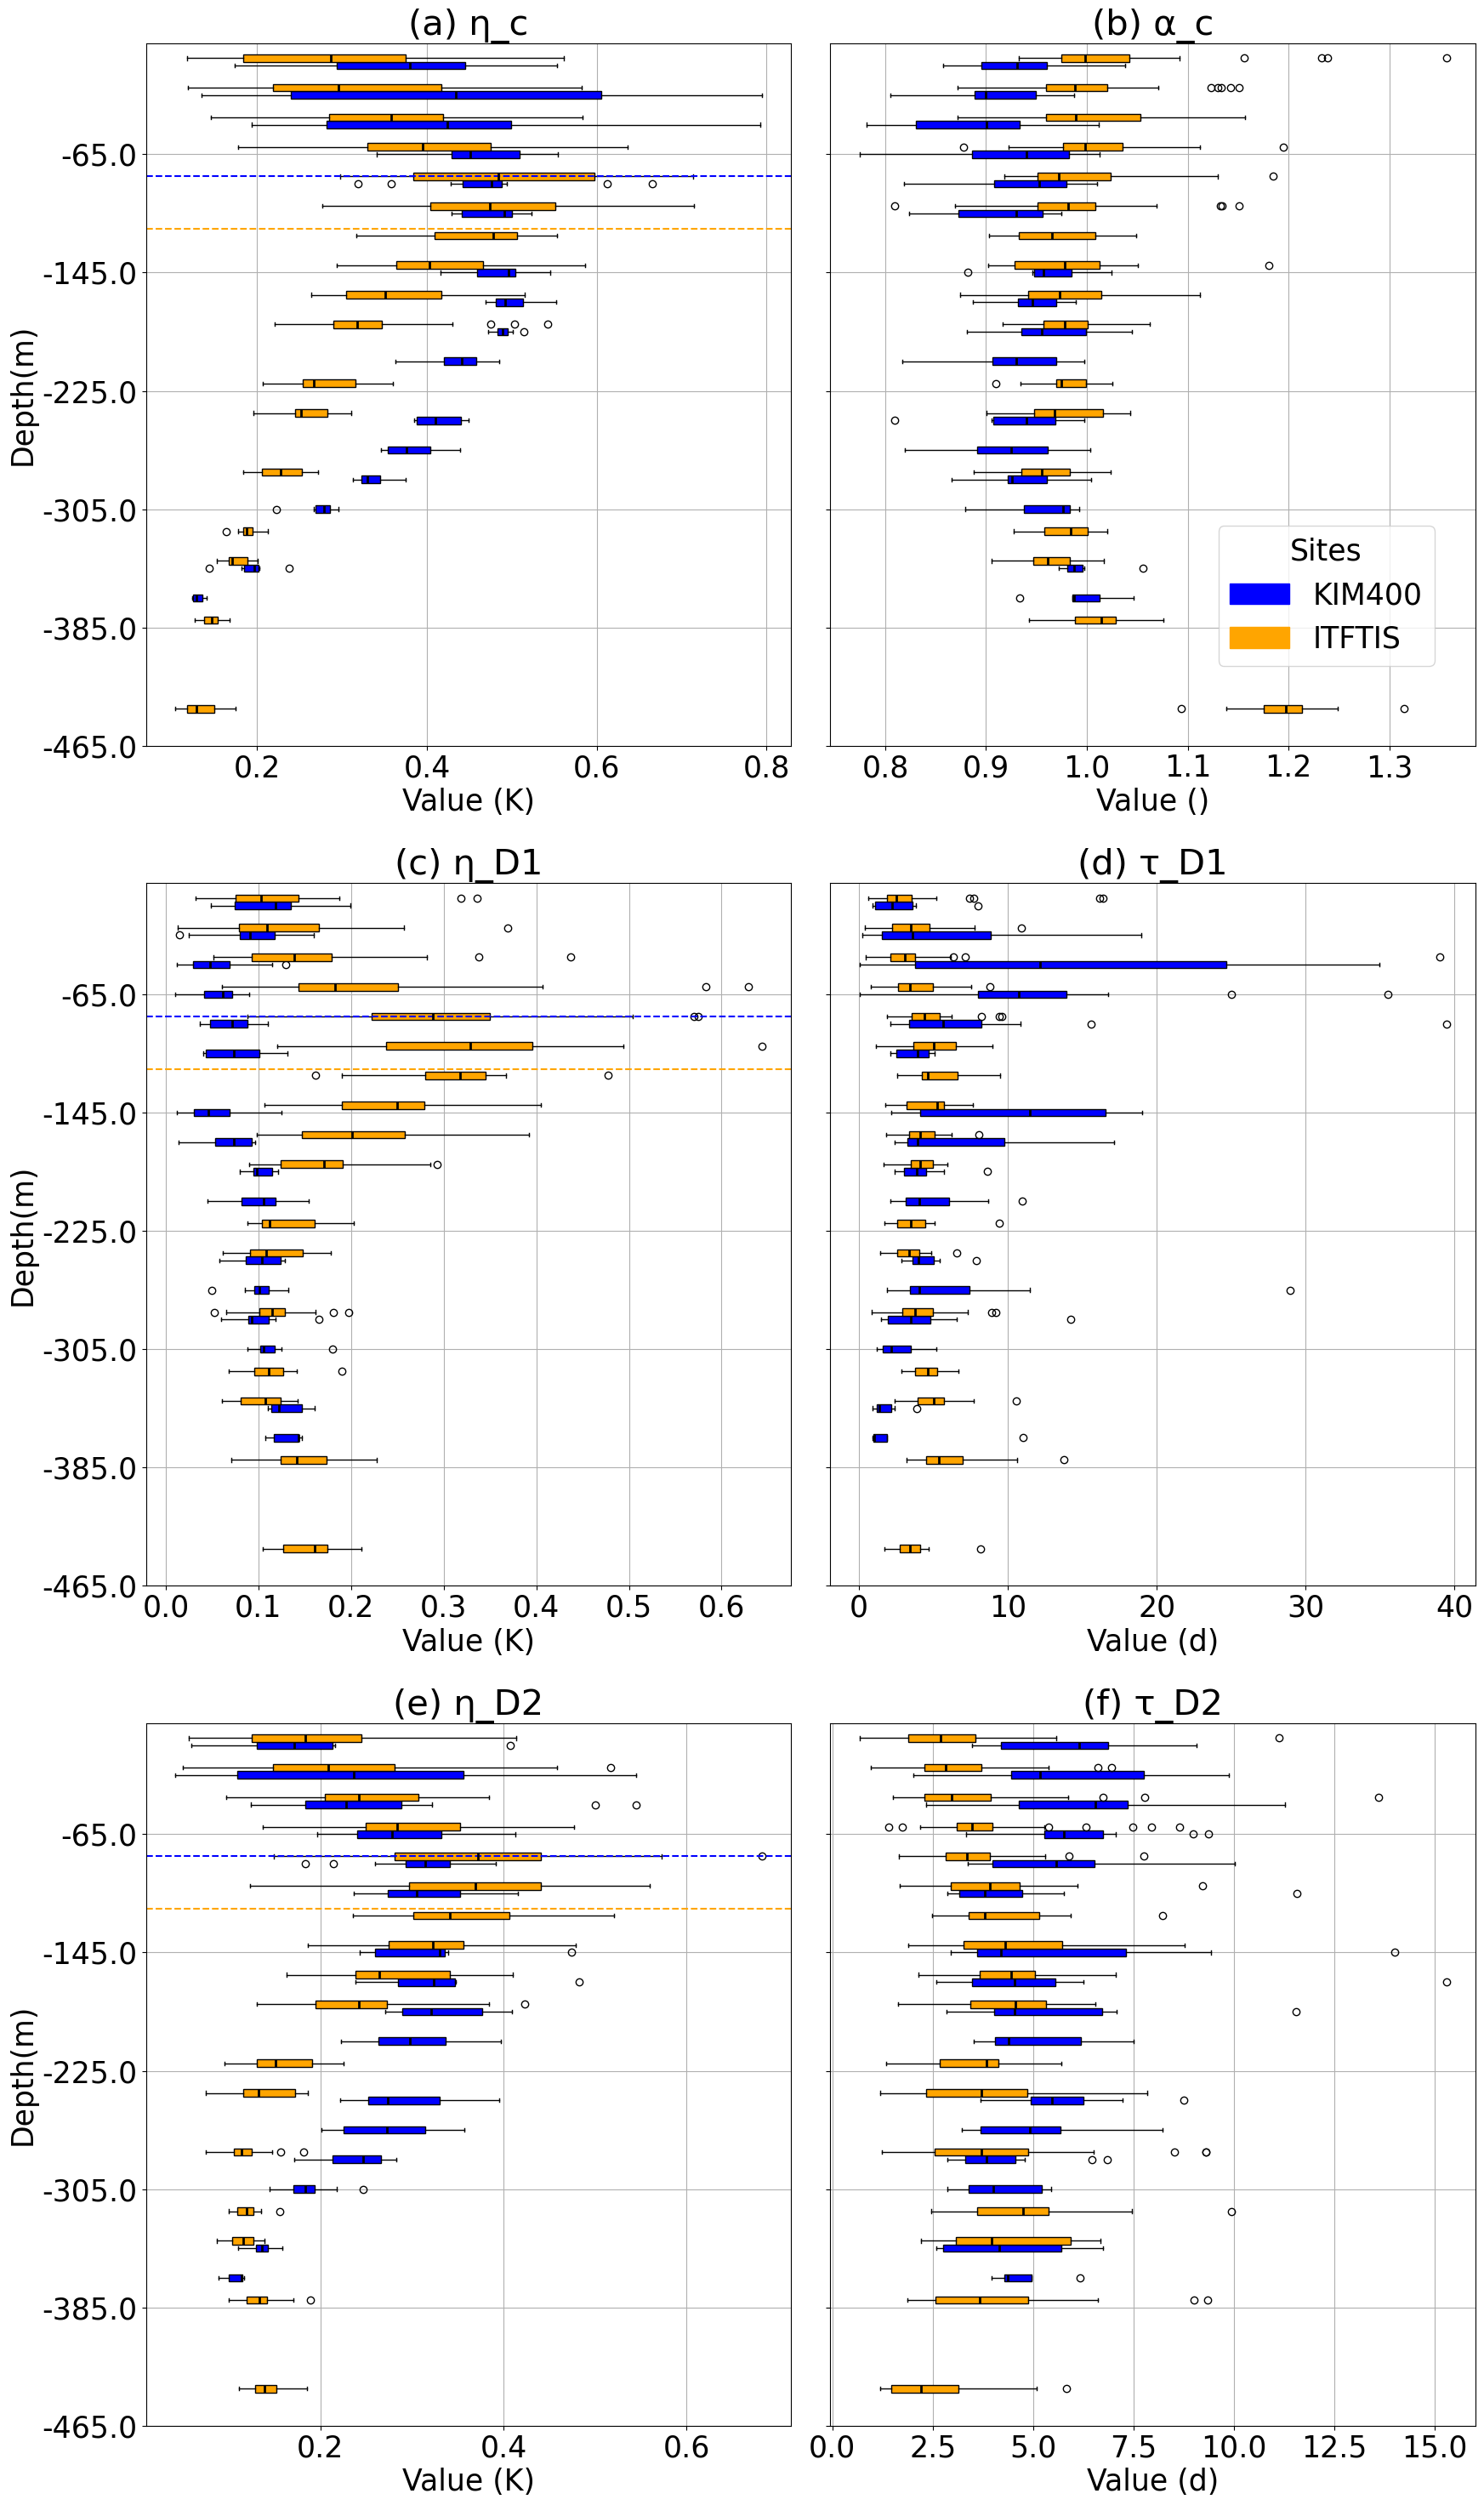

In [226]:
# locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['KIM400','ITFTIS']
lat_list = [-15.22, -9.817,]
bin_size =20 #m
#find the whole depth list
depth_list = np.arange(Whole_Soln_df_M1L2_clean['depth_round'].min(),Whole_Soln_df_M1L2_clean['depth_round'].max()+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1','τ_D1', 'η_D2', 'τ_D2',]
M1L2_parameter_order = ['a','b','c','d','e','f',]
M1L2_parameter_units = ['K','','K','d','K','d',]
# Plot box plot
cols = 2
rows = round(len(M1L2_parameter_name)/cols)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(rows, cols, figsize=(20, 30),sharey=True)
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors = ['blue', 'orange', 'purple','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        #find the data at this location
        data = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==loc].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            data_at_depth = data.loc[(data['depth_round'] >= (depth-bin_size)) & (data['depth_round'] < (depth))][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            #check data length
            if (len(data_clean)>=4):
                axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
#             else:
#                 print('{} at {} has a length less than 4'.format(parameter_name, depth))
        # Customize plot
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
        axes[parameter_order].set_xlabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
        axes[parameter_order].set_yticks(depth_order_list[::4])  # Display depth
        axes[parameter_order].set_yticklabels(depth_list[::4])       # Set depth labels 
        axes[parameter_order].grid(True)
        
#plot the thermocline depth
for i,loc in enumerate(locations):
    avg_thermocline_depth = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,loc,lat_list[i],seasons,threshold=40)
    print(loc,avg_thermocline_depth)
    postision = Estimate_position(avg_thermocline_depth,depth_list)
    for j in [0,2,4]:
        axes[j].axhline(y=postision, color=colors[i], linestyle='--')
    
        
# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(locations, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in locations]
labels = locations   
fig.legend(handles, labels, title='Sites', loc=(0.88,0.25), bbox_to_anchor=(0.73, 0.73))  


for i in range(len(axes)):
    if i%2==0:
        axes[i].set_ylabel('Depth(m)')
    
    
# Show plot
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle to leave space for the y-axis label and legend
plt.savefig('KIM400&ITFTIS depth profile of M1L2 parameter.pdf')
plt.show()

PIL200 -159.37517875847172


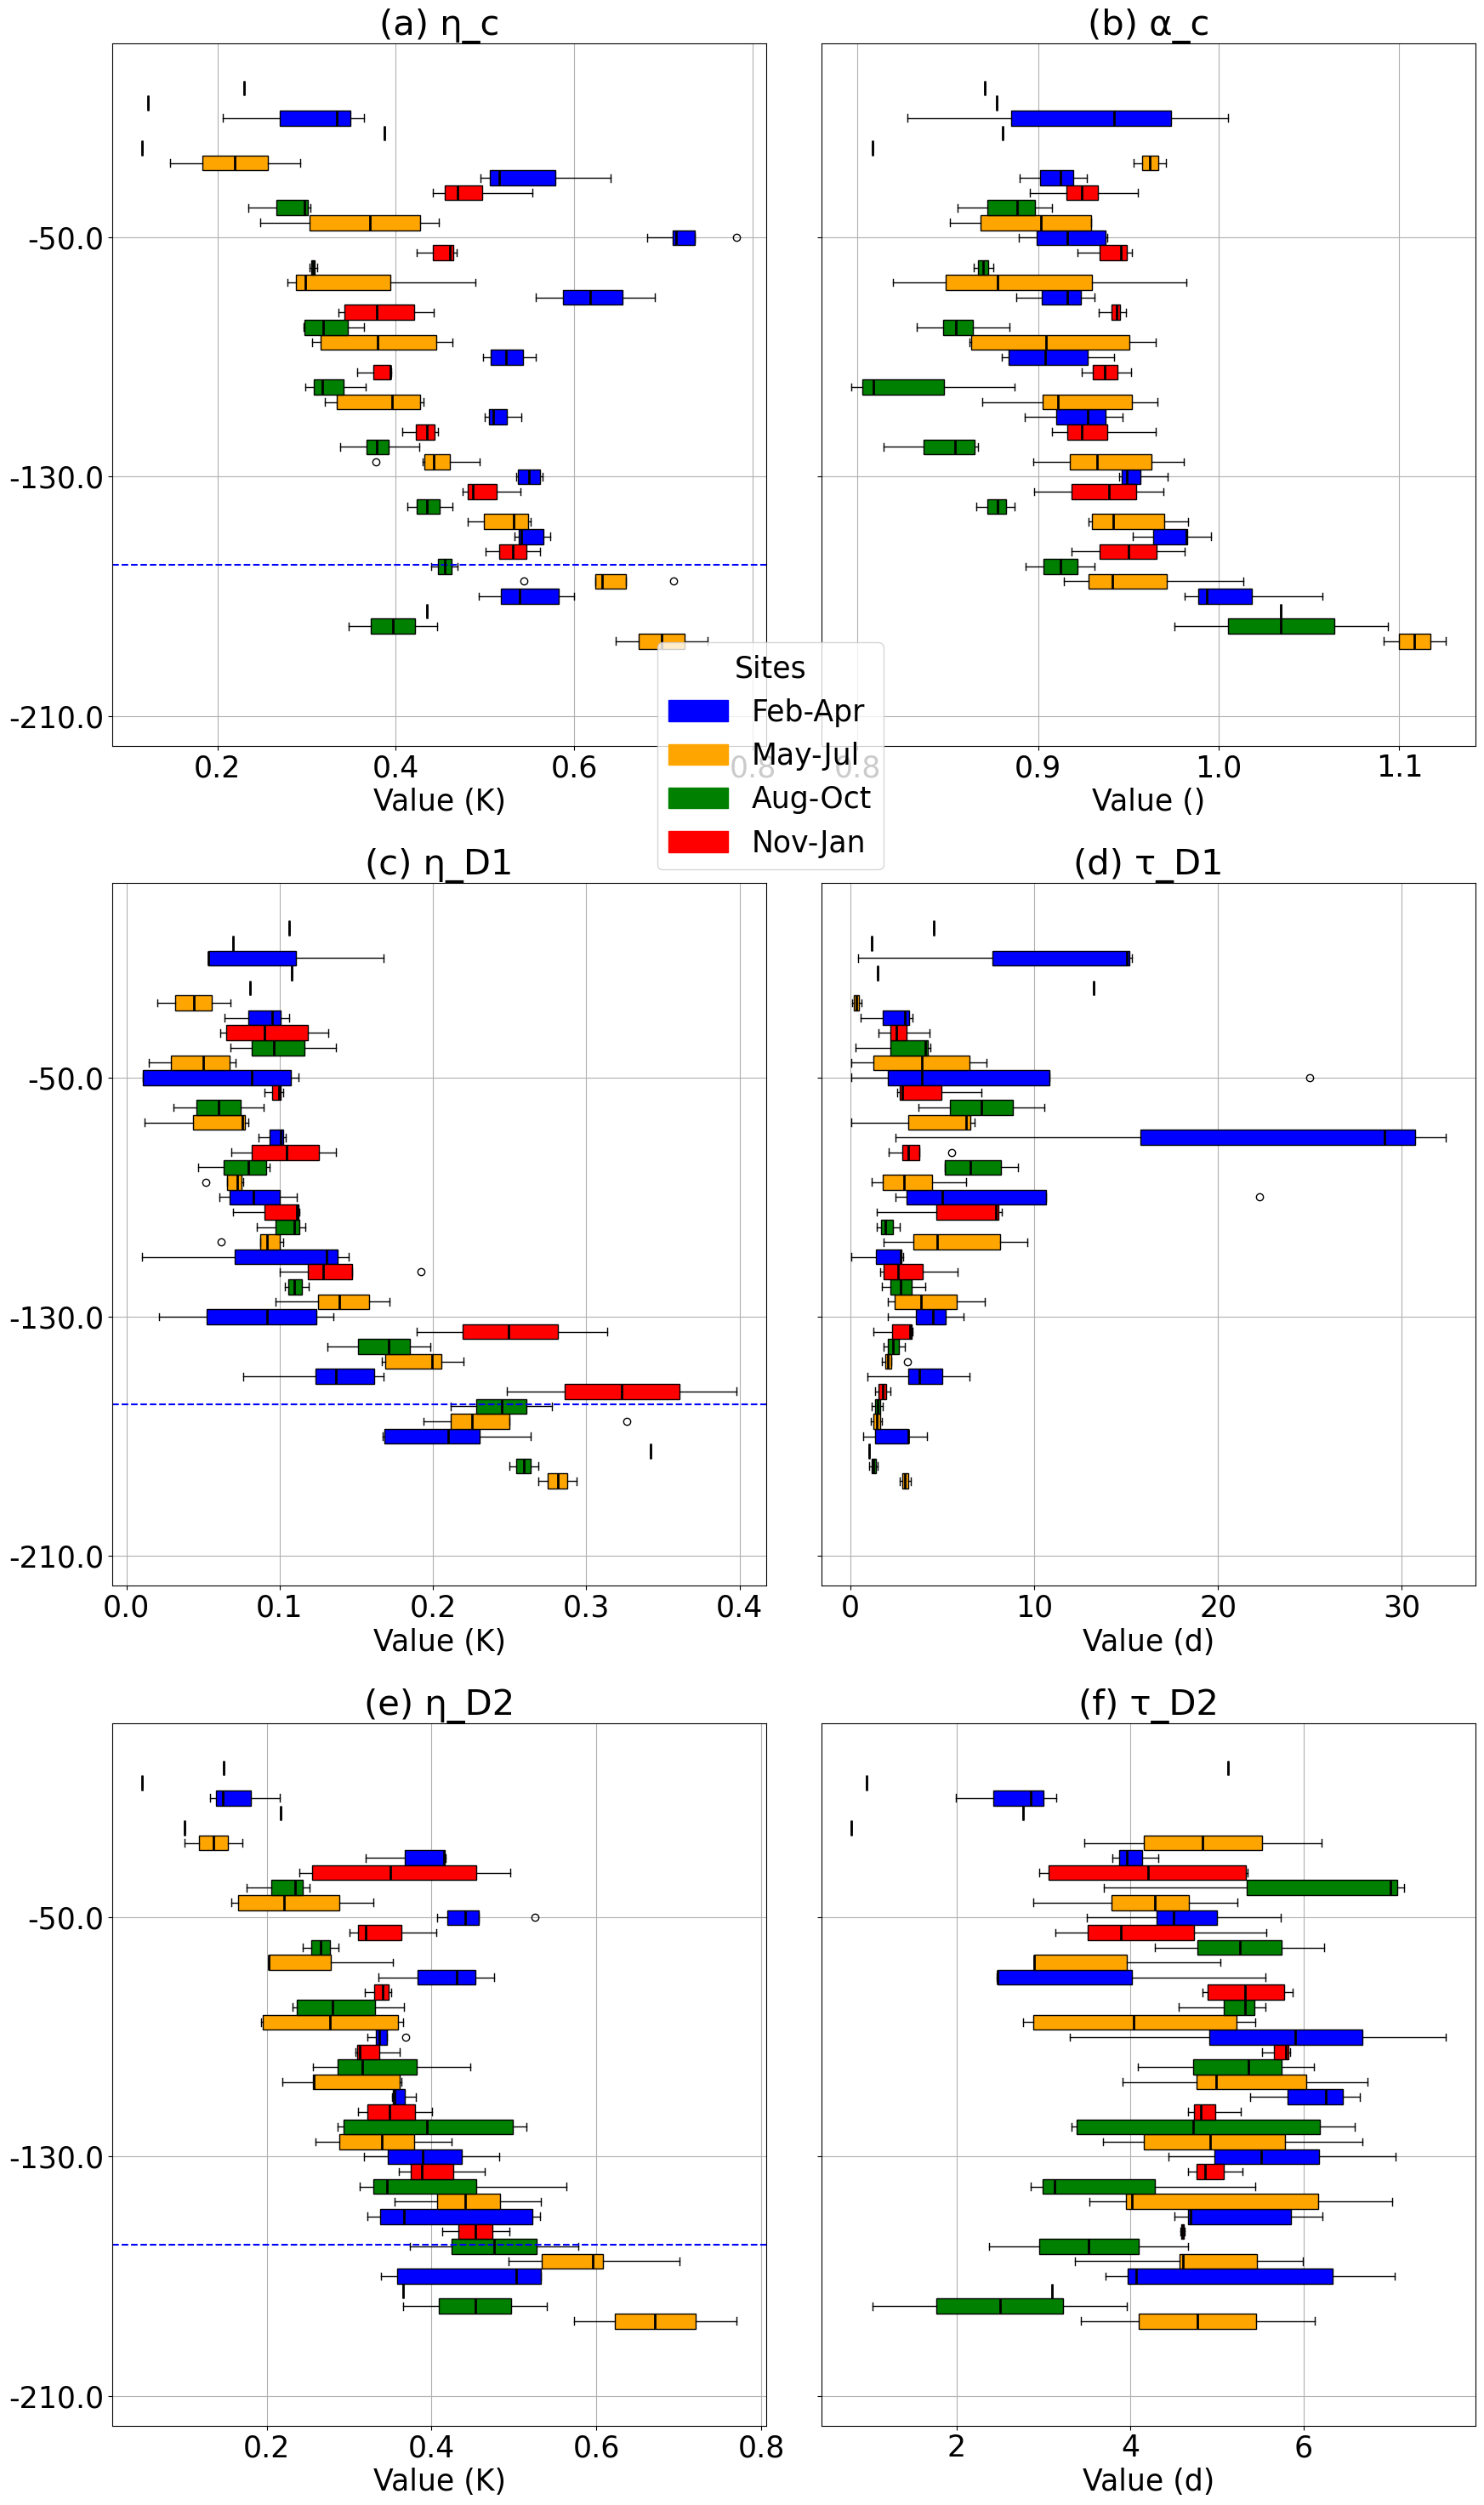

In [324]:
# locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['PIL200']
lat_list = [-19.44,]
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()

bin_size =20 #m
#find the whole depth list
depth_list = np.arange(Whole_Soln_df_M1L2_clean['depth_round'].min(),Whole_Soln_df_M1L2_clean['depth_round'].max()+1,bin_size)  #positive, from shallow to deep
depth_list = np.arange(-210,Whole_Soln_df_M1L2_clean['depth_round'].max()/2+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1','τ_D1', 'η_D2', 'τ_D2',]
M1L2_parameter_order = ['a','b','c','d','e','f',]
M1L2_parameter_units = ['K','','K','d','K','d',]
# Plot box plot
cols = 2
rows = round(len(M1L2_parameter_name)/cols)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(rows, cols, figsize=(20, 30),sharey=True)
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors = ['blue', 'orange', 'green','red'] 

data_at_loc = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==locations[0]].copy()
for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, sea in enumerate(seasons):
        #find the data at this location
        data = data_at_loc.loc[data_at_loc['season'] ==sea].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            data_at_depth = data.loc[(data['depth_round'] >= (depth-bin_size)) & (data['depth_round'] < (depth))][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            #check data length
            # if (len(data_clean)>=4):
            axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
#             else:
#                 print('{} at {} has a length less than 4'.format(parameter_name, depth))
        # Customize plot
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
        axes[parameter_order].set_xlabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
        axes[parameter_order].set_yticks(depth_order_list[::4])  # Display depth
        axes[parameter_order].set_yticklabels(depth_list[::4])       # Set depth labels 
        axes[parameter_order].grid(True)
        
#plot the thermocline depth
for i,loc in enumerate(locations):
    avg_thermocline_depth = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,loc,lat_list[i],seasons,threshold=40)
    print(loc,avg_thermocline_depth)
    postision = Estimate_position(avg_thermocline_depth,depth_list)
    for j in [0,2,4]:
        axes[j].axhline(y=postision, color=colors[i], linestyle='--')
    
# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(seasons, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in seasons]
labels = seasons
fig.legend(handles, labels, title='Sites', loc=(0.88,0.25), bbox_to_anchor=(0.4, 0.65))  


# for i in range(len(axes)):
#     if i%2==0:
#         axes[i].set_ylabel('Depth(m)')
    
    
# Show plot
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle to leave space for the y-axis label and legend
#plt.savefig('KIM400&ITFTIS depth profile of M1L2 parameter.pdf')
plt.show()

## Shallow

KIM200 -115.62544510390002
PIL200 -159.37517875847172


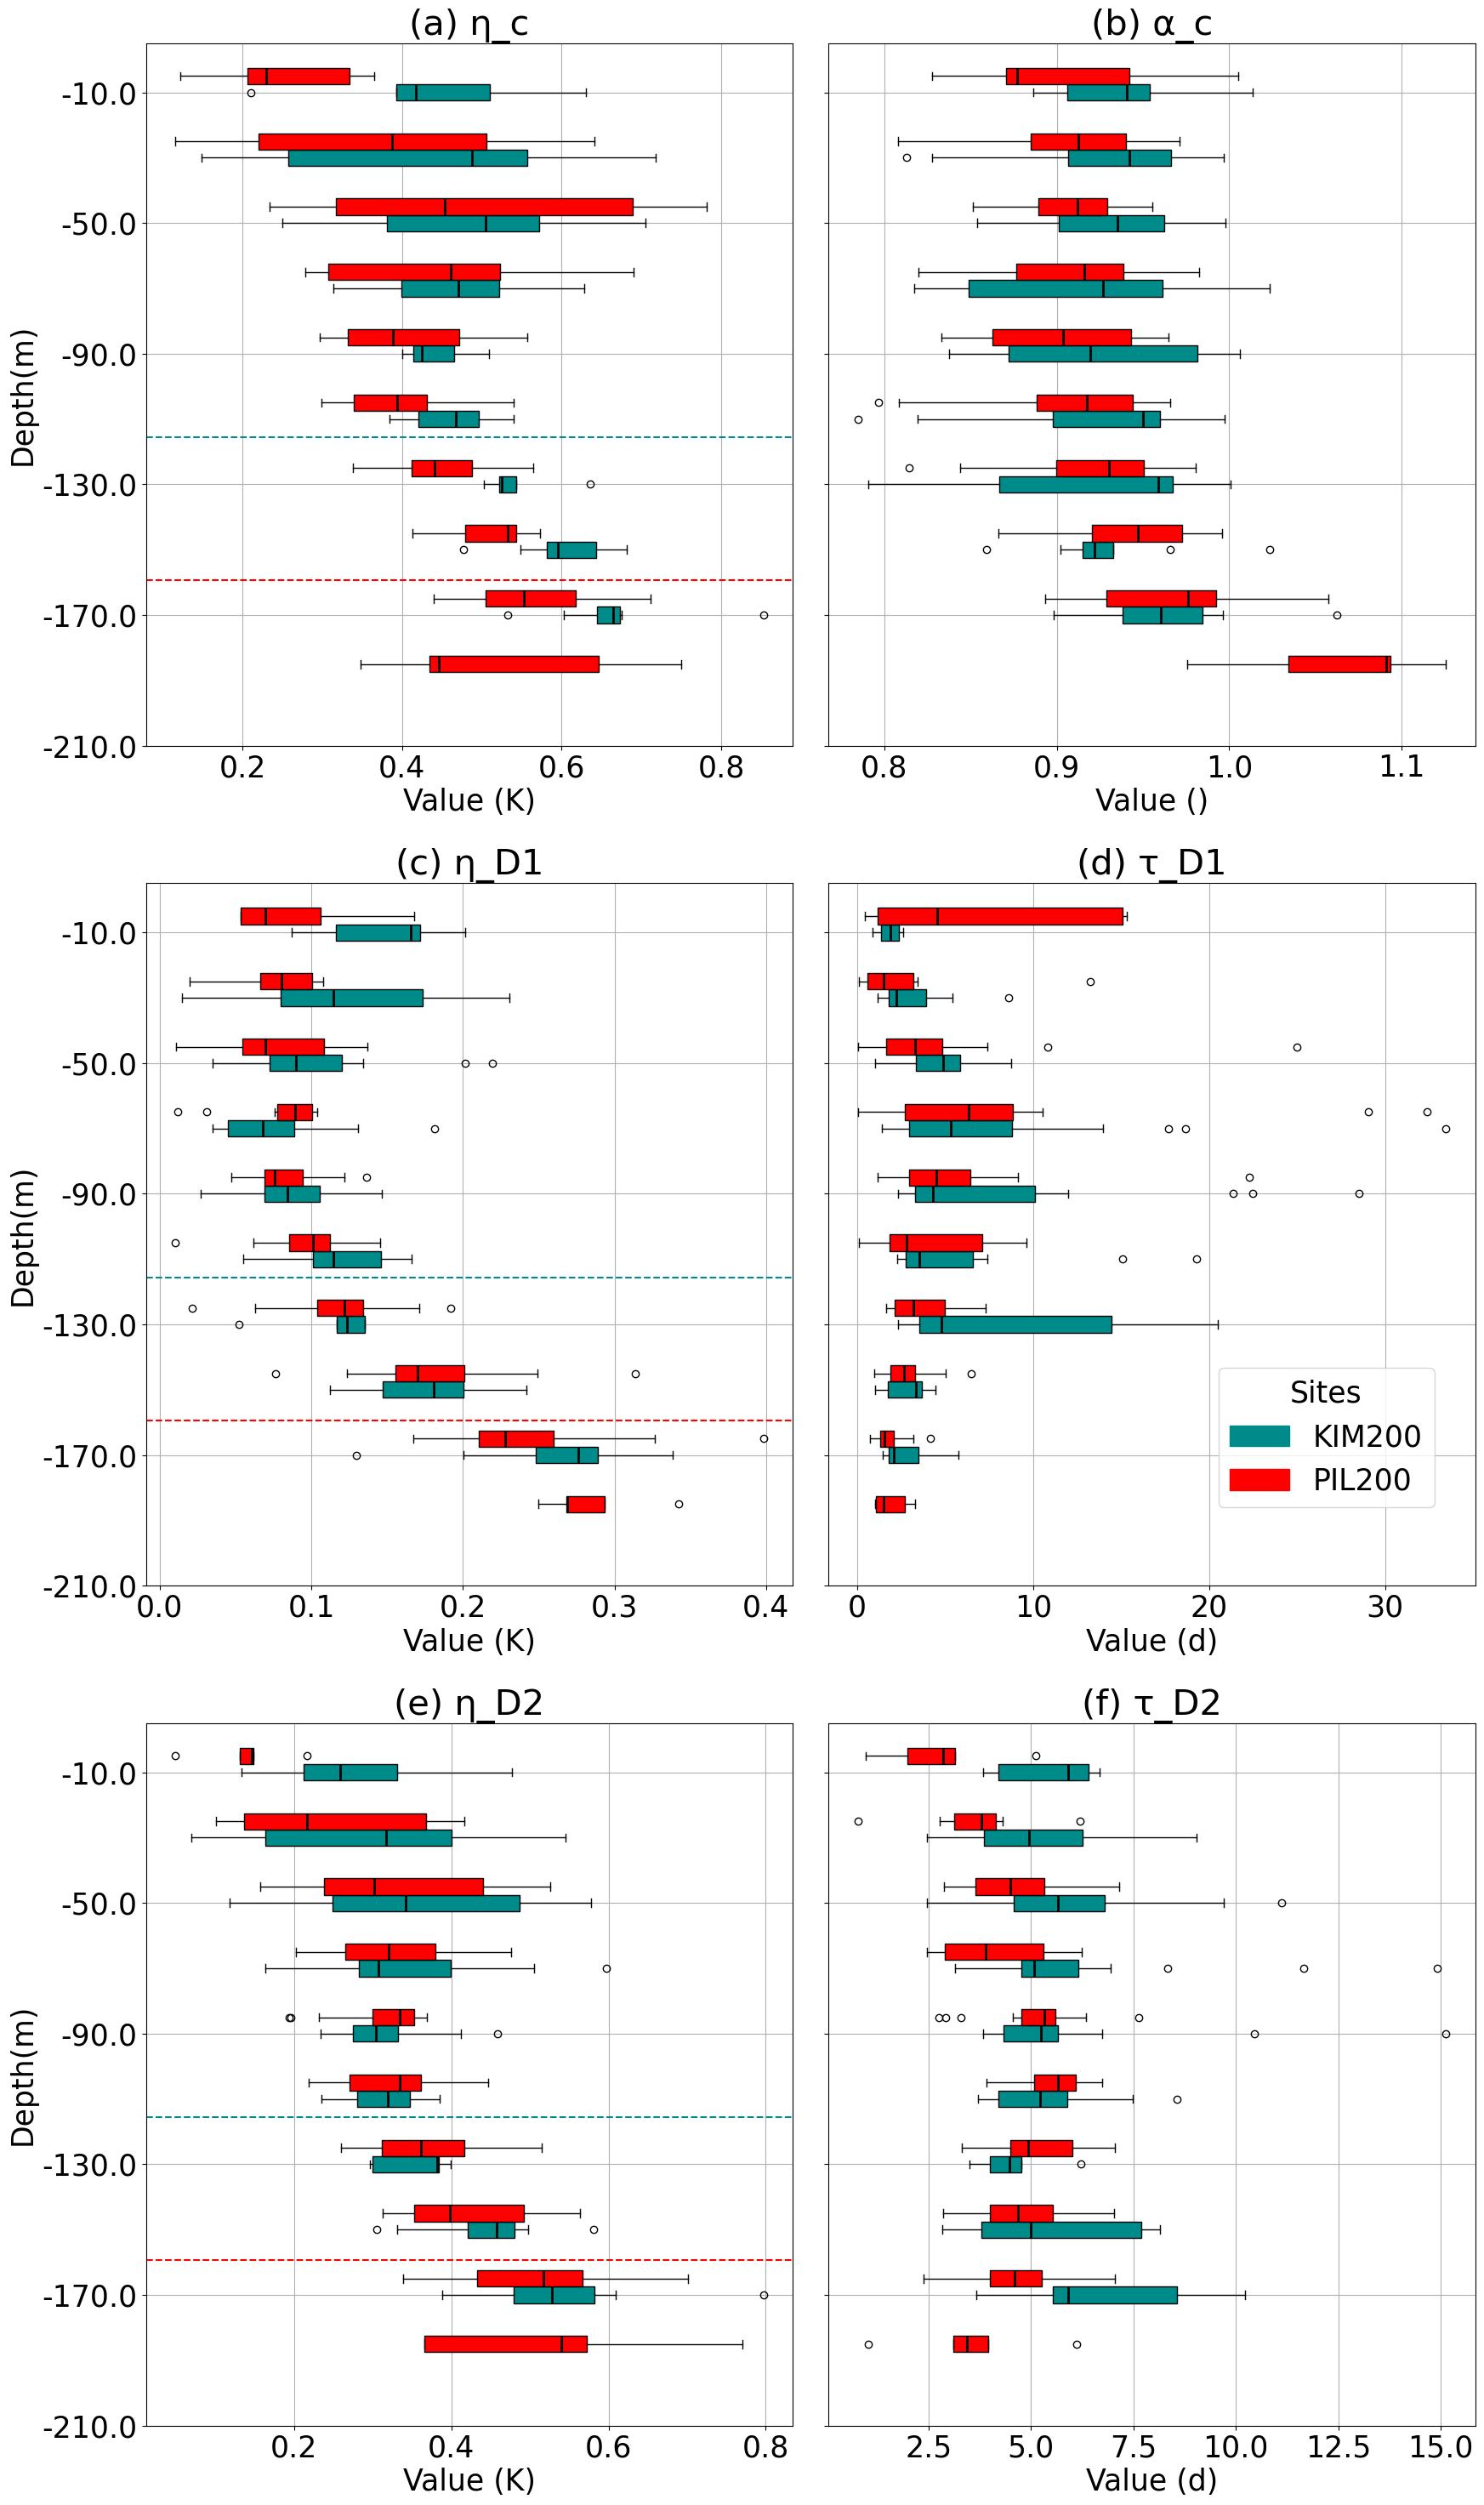

In [316]:
# Plot box plot
locations = ['KIM200','PIL200',]
lat_list = [-15.53,-19.44,]

#find the whole depth list
bin_size = 20
depth_list = np.arange(-210,Whole_Soln_df_M1L2_clean['depth_round'].max()/2+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1','τ_D1', 'η_D2', 'τ_D2',]
M1L2_parameter_order = ['a','b','c','d','e','f',]
M1L2_parameter_units = ['K','','K','d','K','d',]

# Plot box plot
cols = 2
rows = round(len(M1L2_parameter_name)/cols)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(rows, cols, figsize=(20, 30),sharey=True)
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors = ['darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        #find the data at this location
        data = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==loc].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            # the bin is located at the upper limit of bin for the plot
            data_at_depth = data.loc[(data['depth_round'] < depth)&(data['depth_round'] >= (depth-bin_size))][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            if (len(data_clean)>=4):
                axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
#             else:
#                 print('{} at {} has a length less than 4'.format(parameter_name, depth))

        # Customize plot  
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
        axes[parameter_order].set_xlabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
        axes[parameter_order].set_yticks(depth_order_list[::2])  # Display every fifth depth
        axes[parameter_order].set_yticklabels(depth_list[::2])       # Set labels for every fifth depth
        axes[parameter_order].grid(True)

#plot the thermocline depth
for i,loc in enumerate(locations):
    avg_thermocline_depth = Find_avg_thermocline_depth(Whole_Soln_df_M1L2_clean,loc,lat_list[i],seasons,threshold=40)
    print(loc,avg_thermocline_depth)
    postision = Estimate_position(avg_thermocline_depth,depth_list)
    for j in [0,2,4]:
        axes[j].axhline(y=postision, color=colors[i], linestyle='--')
    
# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(locations, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in locations]
labels = locations   

for i in range(len(axes)):
    if i%2==0:
        axes[i].set_ylabel('Depth(m)')
fig.legend(handles, labels, title='Sites', loc=(0.88,0.25), bbox_to_anchor=(0.73, 0.4))  
   
# Show plot
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle to leave space for the y-axis label and legend
# Show plot
plt.savefig('KIM200&PIL200 depth profile of M1L2 parameter.pdf')
plt.show()

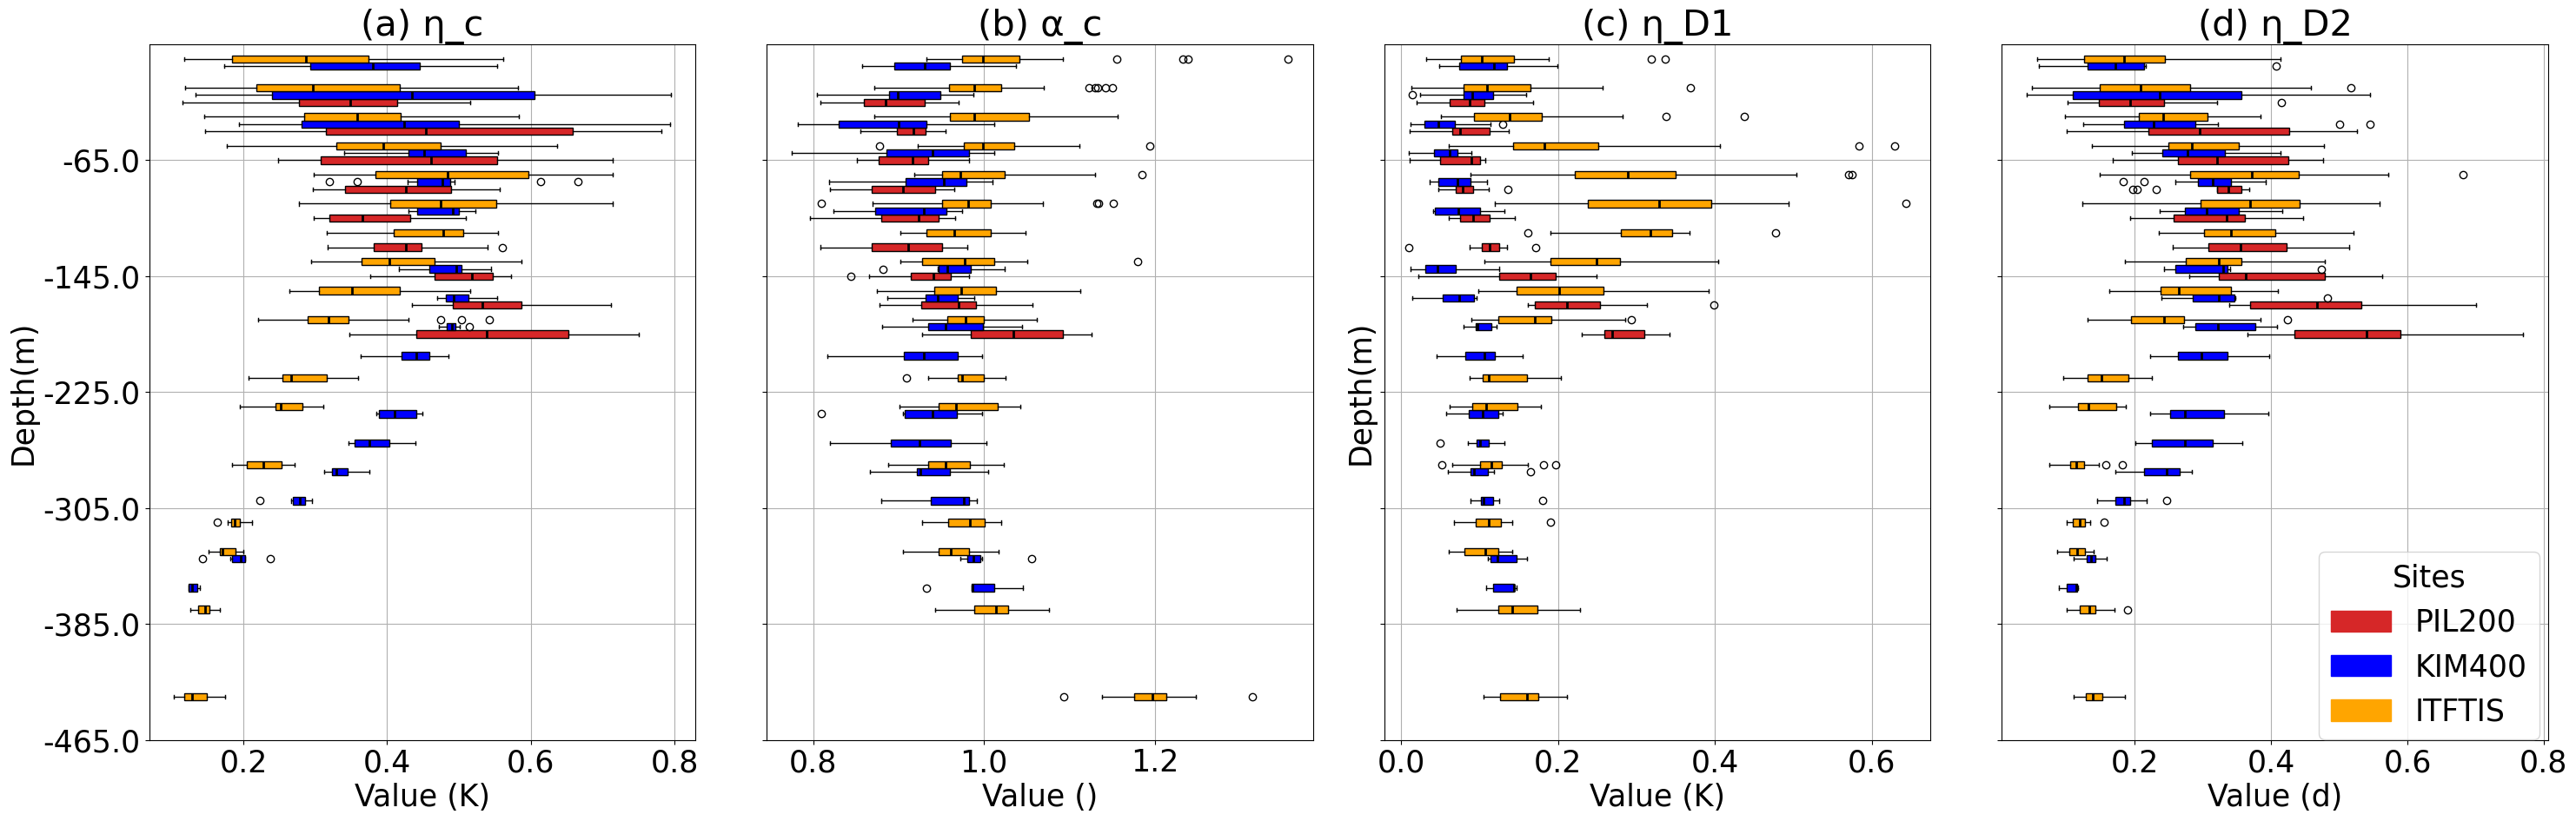

In [229]:
# locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['PIL200','KIM400','ITFTIS',]
lat_list = [-19.44,-15.22, -9.817,]
bin_size = 20 #m
#find the whole depth list
depth_list = np.arange(Whole_Soln_df_M1L2_clean['depth_round'].min(),Whole_Soln_df_M1L2_clean['depth_round'].max()+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1', 'η_D2',]
M1L2_parameter_order = ['a','b','c','d','e','f']
M1L2_parameter_units = ['K','','K','d','K','d',]
# Plot box plot
cols = 4
rows = round(len(M1L2_parameter_name)/cols)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(rows, cols, figsize=(30, 10),sharey=True)
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors = ['tab:red','blue', 'orange', ]  

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        #find the data at this location
        data = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==loc].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            data_at_depth = data.loc[(data['depth_round'] >= (depth-bin_size)) & (data['depth_round'] < (depth))][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            #check data length
            if (len(data_clean)>=4):
                axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
#             else:
#                 print('{} at {} has a length less than 4'.format(parameter_name, depth))
        # Customize plot
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
        axes[parameter_order].set_xlabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
        axes[parameter_order].set_yticks(depth_order_list[::4])  # Display depth
        axes[parameter_order].set_yticklabels(depth_list[::4])       # Set depth labels 
        axes[parameter_order].grid(True)
        

# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(locations, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in locations]
labels = locations   
fig.legend(handles, labels, title='Sites', loc=(0.9,0.1),)  


for i in range(len(axes)):
    if i%2==0:
        axes[i].set_ylabel('Depth(m)')
    
    
# Show plot
fig.tight_layout()  # Adjust the rectangle to leave space for the y-axis label and legend
plt.show()

# Seasonal variability

## At the thermocline depth 

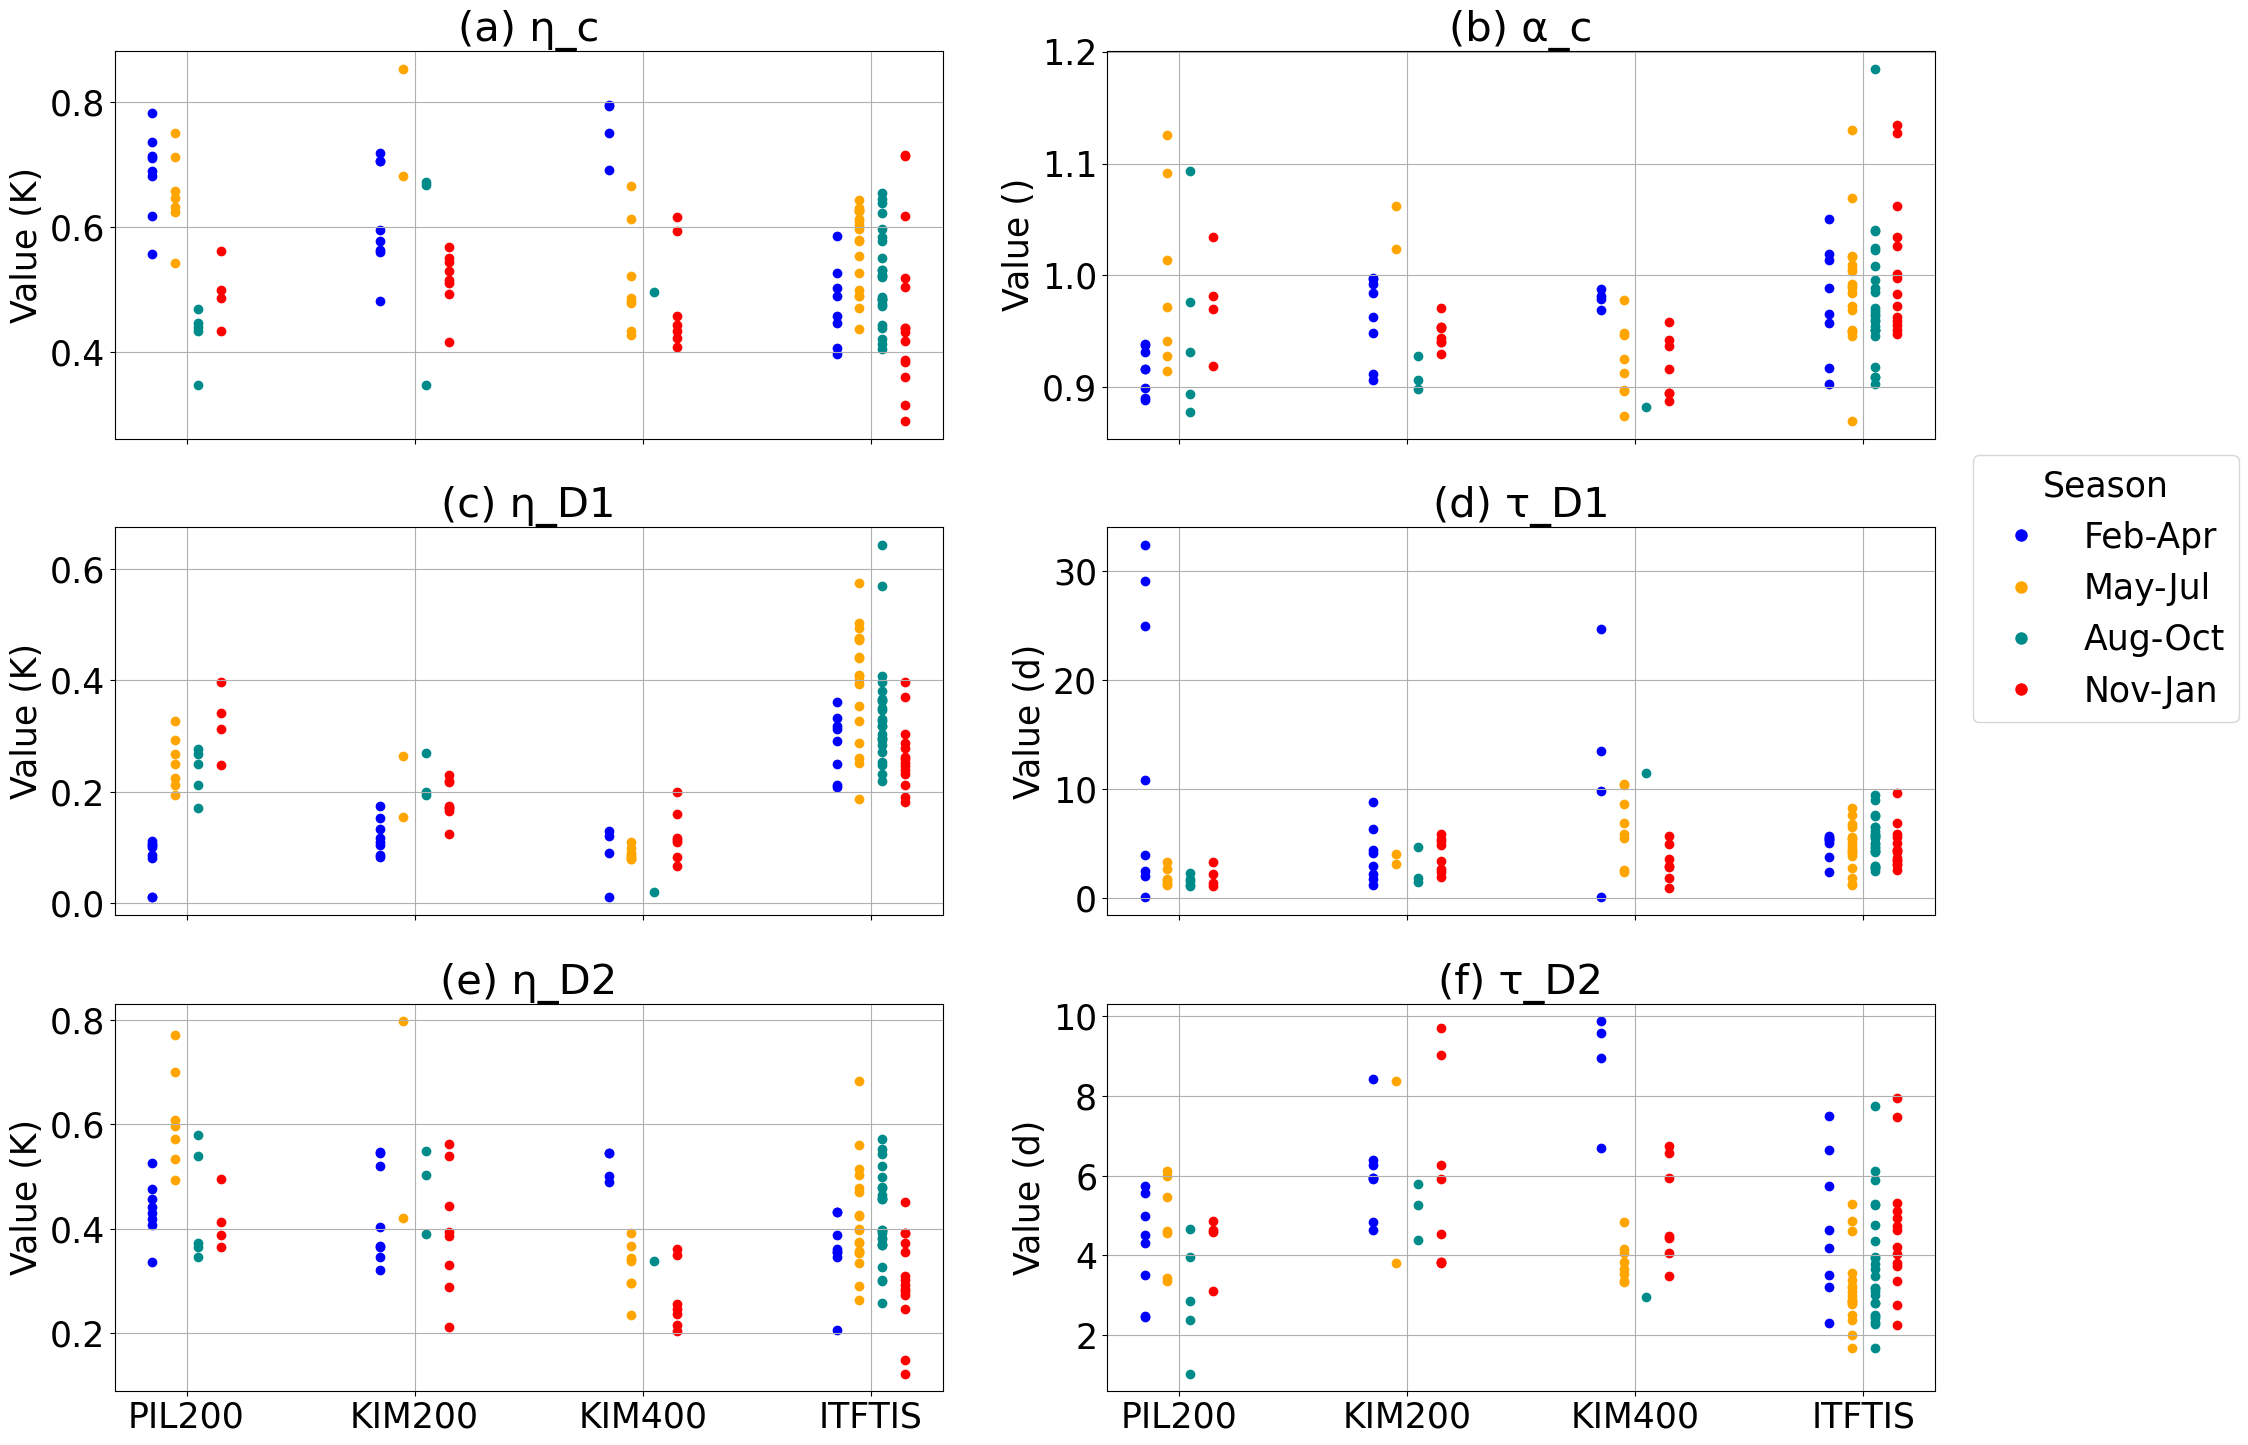

In [232]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D1',   'τ_D1','η_D2', 'τ_D2',]
lat_list = [-19.44,-17.76,-15.53,-15.22,-9.817,]
threshold = 20 #m
# Create a box plot
#PLOT
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15),sharex=True)
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #find the depth of max η_c
            max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
            #select the data at the depth of max η_c
            data = data.loc[(data['depth_round'] > max_value_depth_down)
                            &(data['depth_round'] < max_value_depth_up)][parameter_name].values
            data_clean = [x for x in data if not np.isnan(x)]
            x_positions = np.full(len(data_clean), i + j * width)
            axes[parameter_order].scatter(x_positions, data_clean, color=colors[j])
            
       # Customize plot
    axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))                                   
    axes[parameter_order].set_xticks(positions + (len(seasons) - 1) * width / 2)
    axes[parameter_order].set_xticklabels(locations)
    axes[parameter_order].set_ylabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
    axes[parameter_order].grid(True)

# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=season_legend[season], markersize=10) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.88,0.25), bbox_to_anchor=(1, 0.5))  


# Show plot
plt.tight_layout()
#plt.savefig('Seasonal_variability_of_M1L2_parameter_at_max_eta.pdf')
plt.show()

## At the all depth 

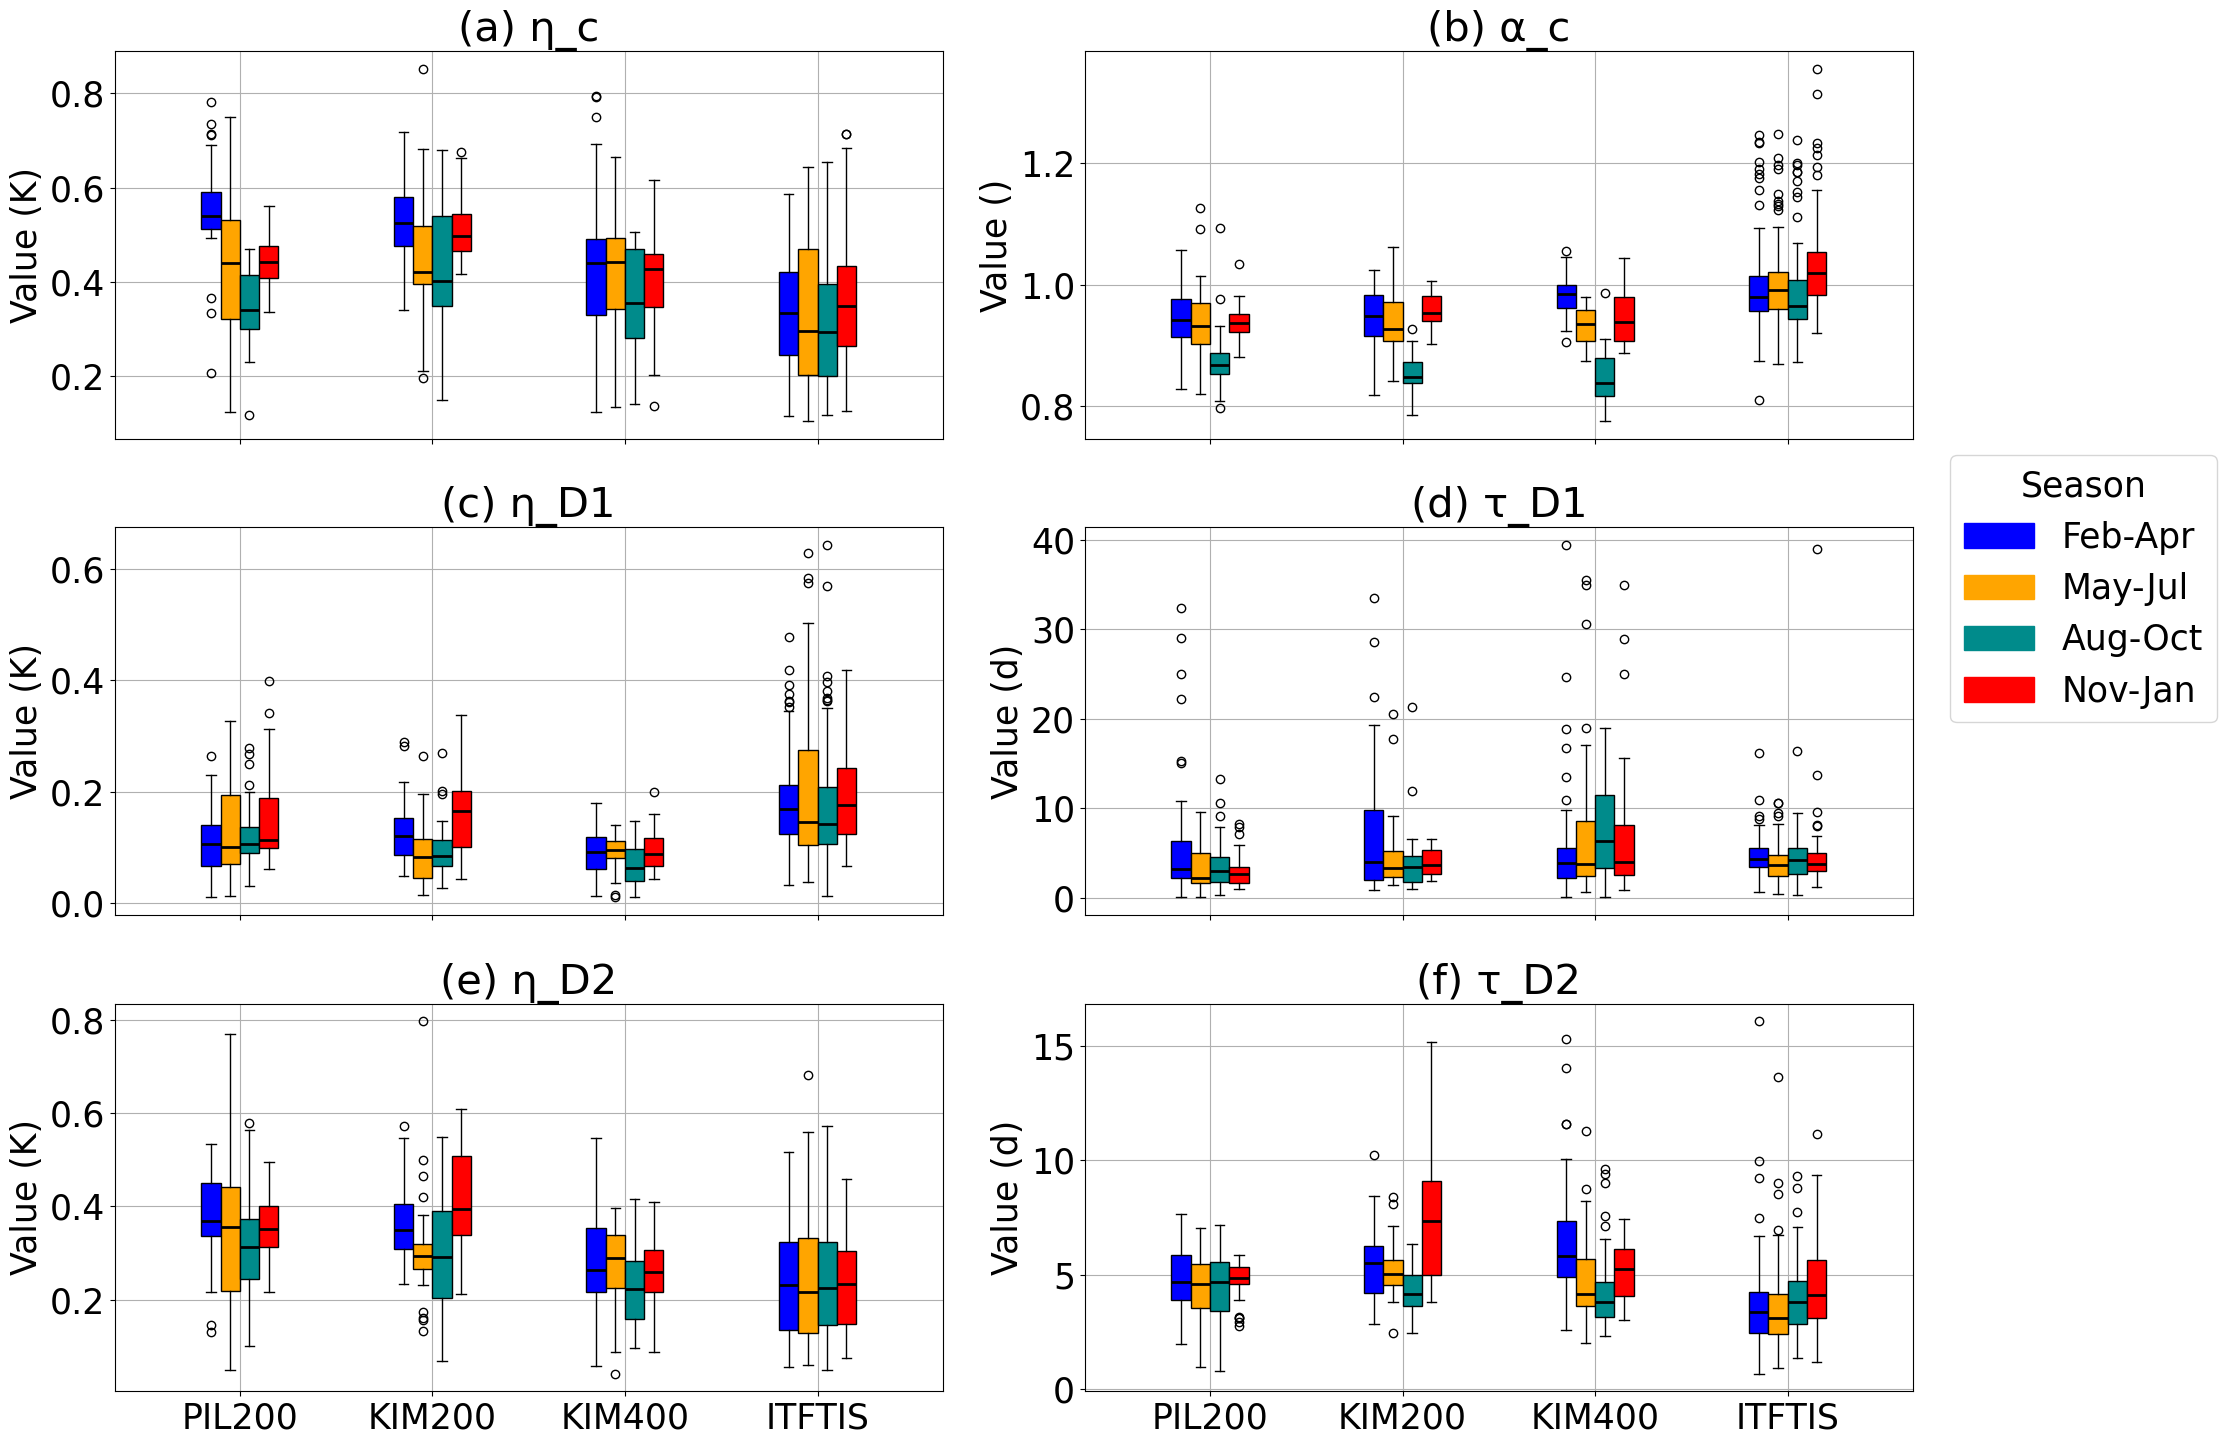

In [235]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D1',   'τ_D1','η_D2', 'τ_D2']
lat_list = [-19.44,-17.76,-15.53,-15.22,-9.817,]
threshold = 20 #m
# Create a box plot
#PLOT
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15),sharex=True)
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red']  

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #find the depth of max η_c
            max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
            #select the data at the depth of max η_c
            data = data[parameter_name].values
            data_clean = [x for x in data if not np.isnan(x)]
            if len(data_clean)>4:
                axes[parameter_order].boxplot(data_clean,
                                              positions=[i + j * width], 
                                              widths=width, patch_artist=True,
                                              boxprops=dict(facecolor=colors[j]),
                                              medianprops=dict(color='black', linewidth=2))

    # Customize plot
    axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))                                 
    axes[parameter_order].set_xticks(positions + (len(seasons) - 1) * width / 2)
    axes[parameter_order].set_xticklabels(locations)
    axes[parameter_order].set_ylabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
    axes[parameter_order].grid(True)    

# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Rectangle((0,0),1,1, color=season_legend[season]) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.88,0.25),bbox_to_anchor=(1, 0.5))  
    
# Show plot
plt.tight_layout()
# plt.savefig('Seasonal variability of M1L2 parameter at max eta.pdf')
plt.show()

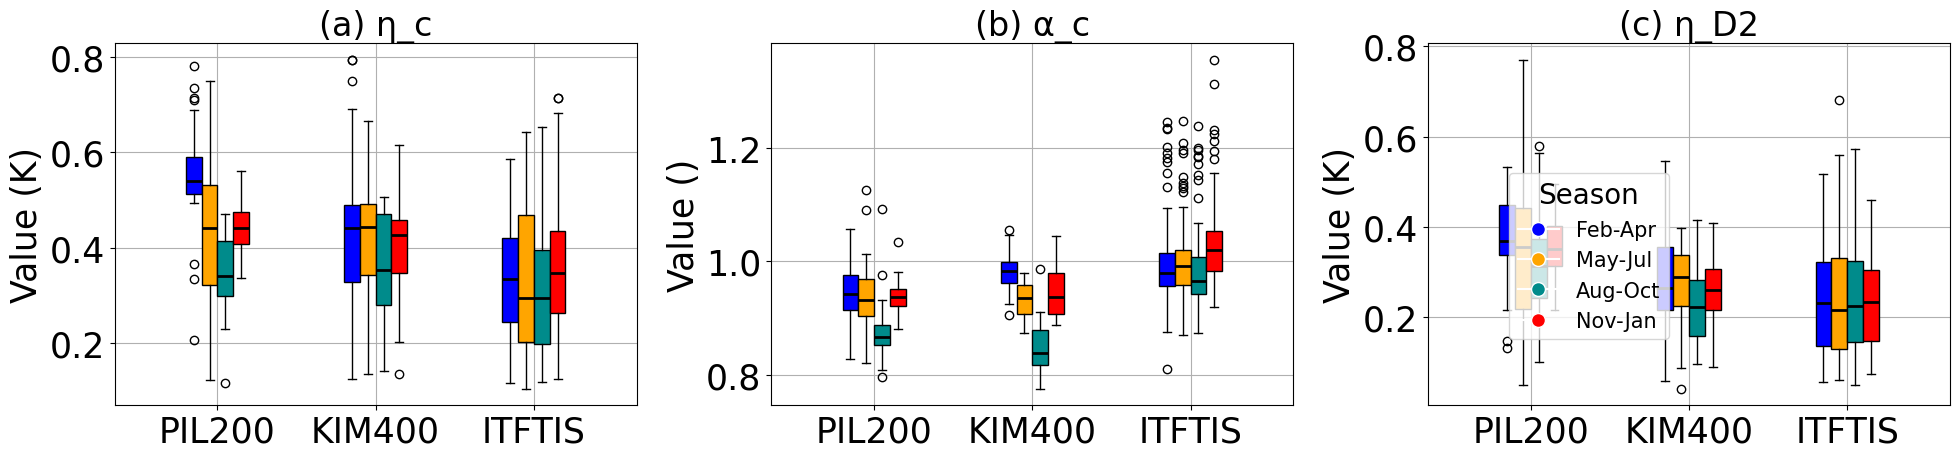

In [236]:
#depths for max η_c
locations = ['PIL200','KIM400','ITFTIS',]
lat_list = [-19.44,-15.22, -9.817,]
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D2',]
threshold = 20 #m
# Create a box plot
#PLOT
cols = 3
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(20, 5),sharex=True)
plt.rcParams['font.size'] = 20
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red']  

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #find the depth of max η_c
            max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
            #select the data at the depth of max η_c
            data = data[parameter_name].values
            data_clean = [x for x in data if not np.isnan(x)]
            if len(data_clean)>4:
                axes[parameter_order].boxplot(data_clean,
                                              positions=[i + j * width], 
                                              widths=width, patch_artist=True,
                                              boxprops=dict(facecolor=colors[j]),
                                              medianprops=dict(color='black', linewidth=2))

    # Customize plot
    axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))                                 
    axes[parameter_order].set_xticks(positions + (len(seasons) - 1) * width / 2)
    axes[parameter_order].set_xticklabels(locations)
    axes[parameter_order].set_ylabel('Value ({})'.format(M1L2_parameter_units[parameter_order]))
    axes[parameter_order].grid(True)    

# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=season_legend[season], markersize=10) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.77,0.26),fontsize=15)  
    
# Show plot
plt.tight_layout()
# plt.savefig('Seasonal variability of M1L2 parameter at max eta.pdf')
plt.show()

## Both thermocline depth and whole depth

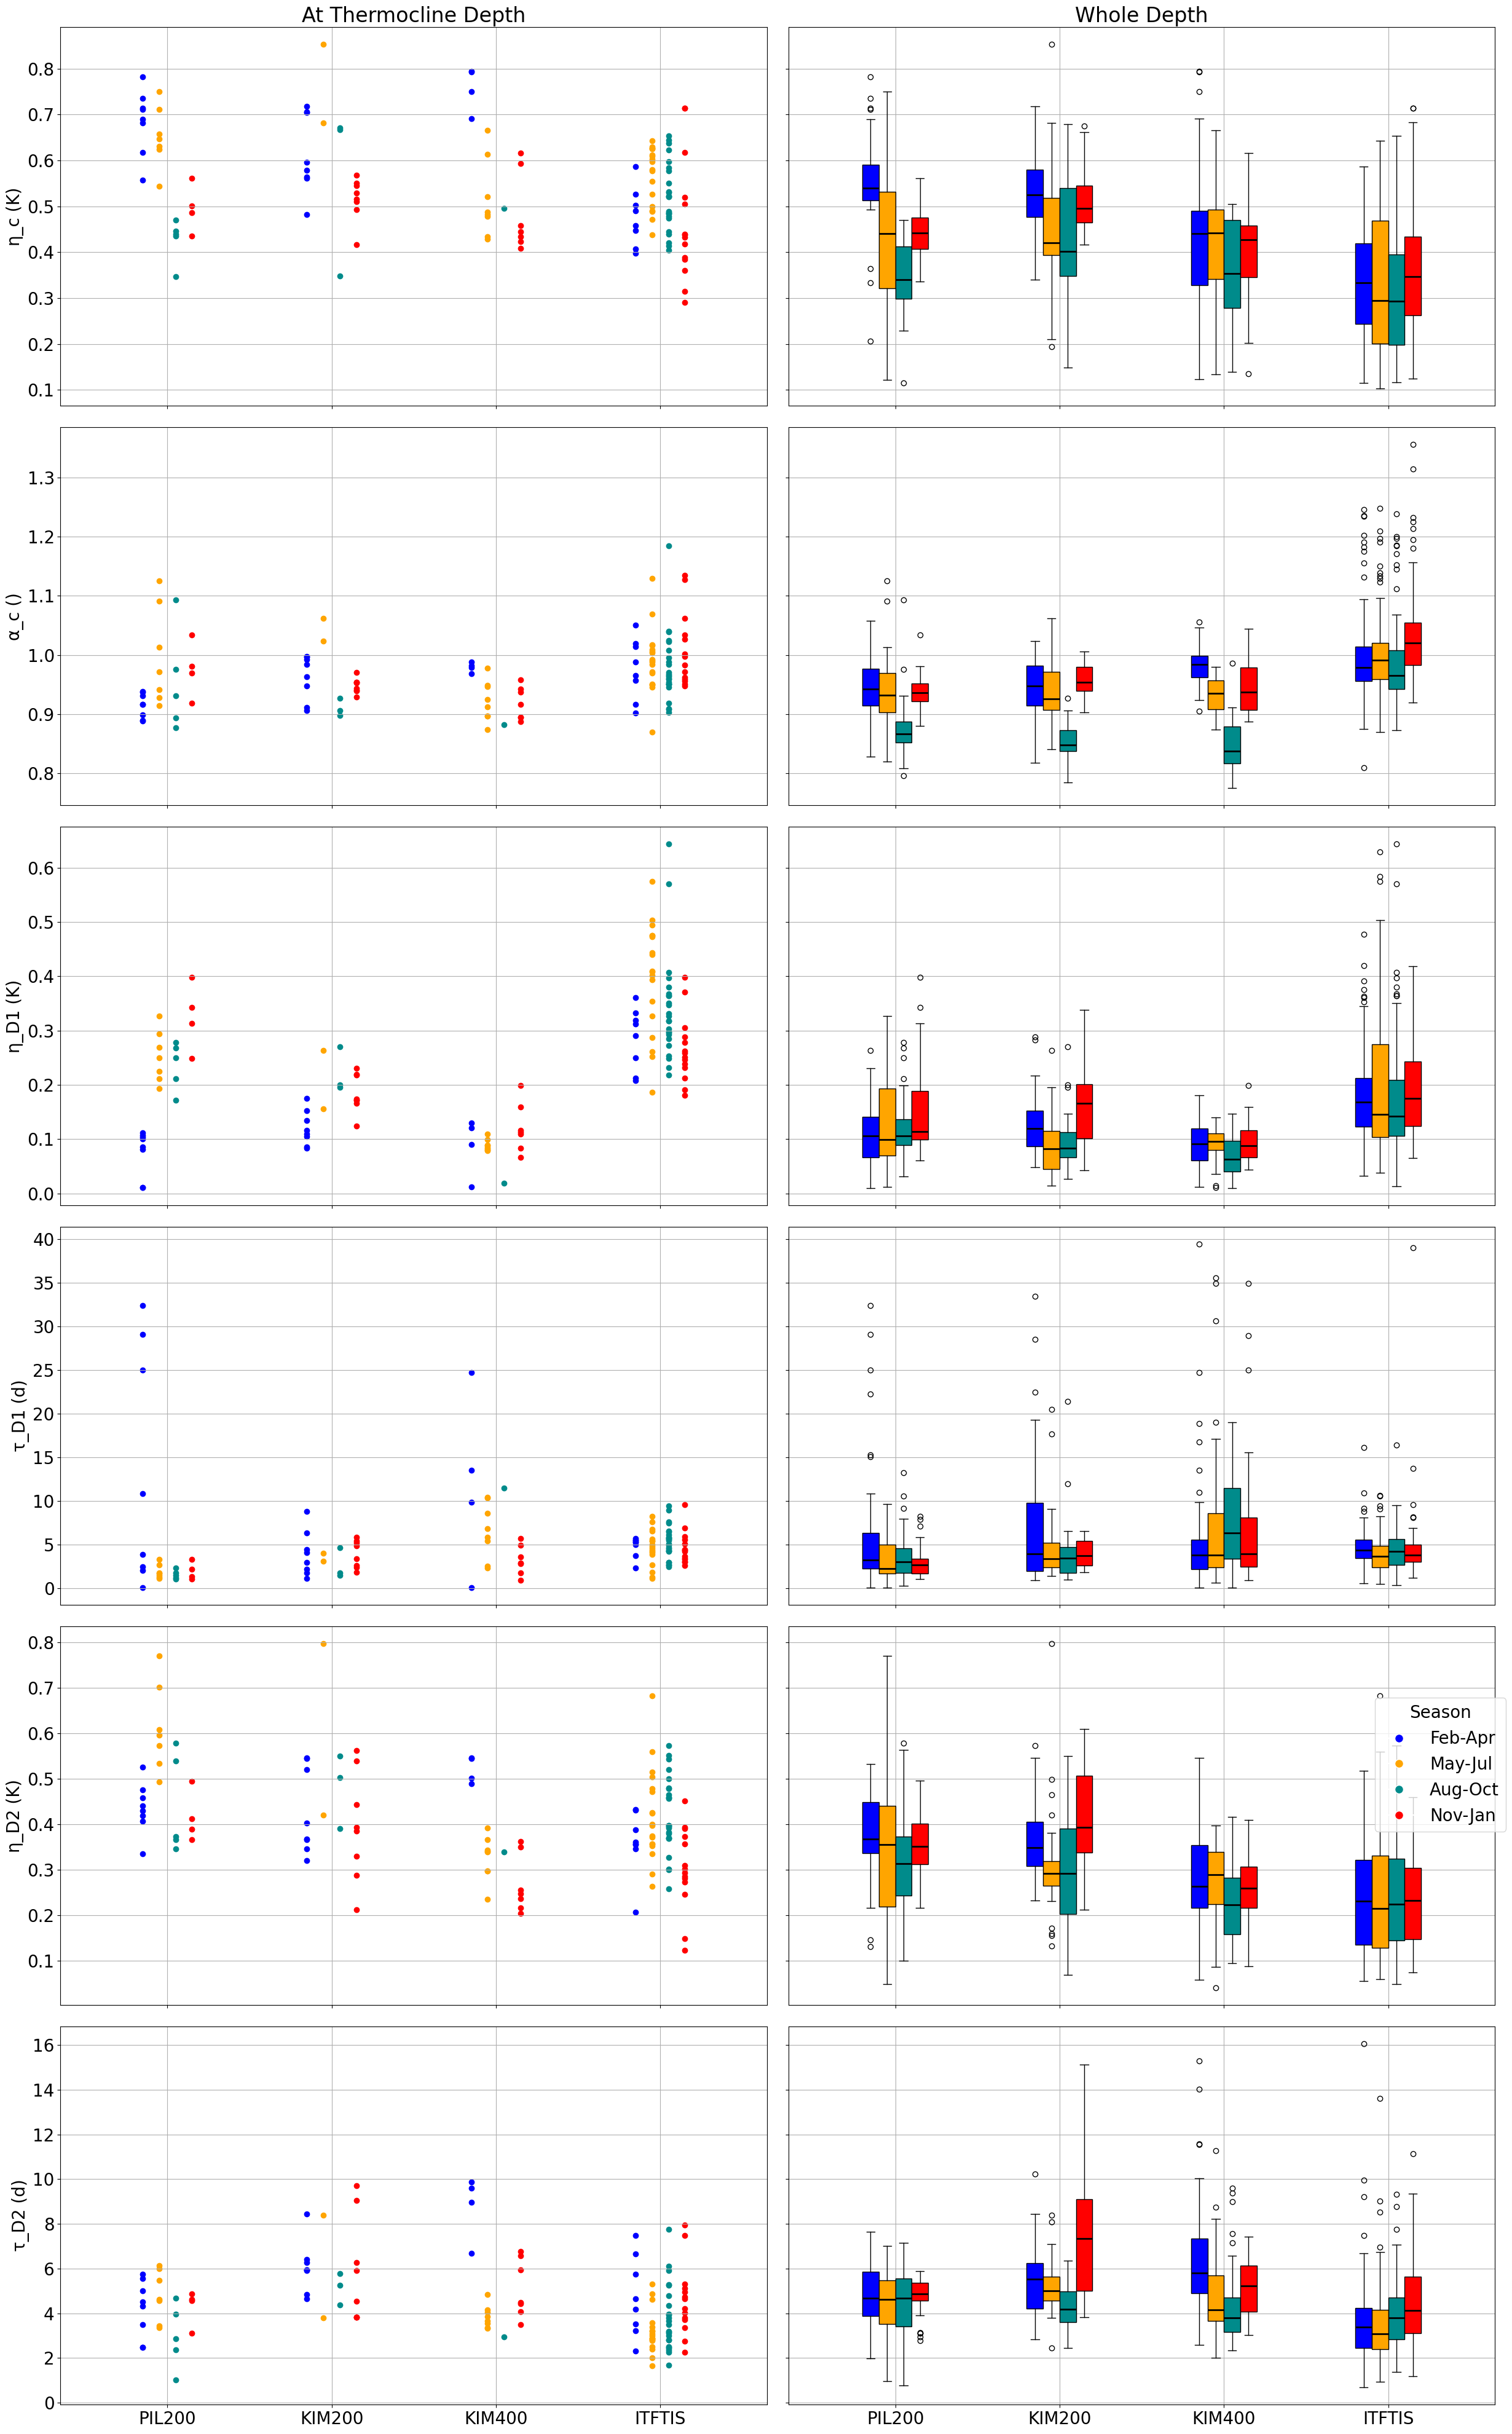

In [238]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D1', 'τ_D1','η_D2', 'τ_D2']
M1L2_parameter_units = ['K','','K','d','K','d',]
lat_list = [-19.44,-17.76,-15.53,-15.22,-9.817,]
threshold = 20 #m
# Create a box plot
#PLOT
cols = 2
rows = 6
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(rows, cols, figsize=(25, 40),sharey='row',sharex=True)
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 


for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #find the depth of max η_c
            max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
            #select the data at the depth of max η_c
            data_at_η_max = data.loc[(data['depth_round'] > max_value_depth_down)
                                &(data['depth_round'] < max_value_depth_up)][parameter_name].values
            data_whole = data[parameter_name].values
            x_positions = np.full(len(data_at_η_max), i + j * width)
            #plot scatter for depth of max η_c
            axes[parameter_order*2].scatter(x_positions, data_at_η_max, color=colors[j])
            axes[parameter_order*2].set_ylabel('{} ({})'.format(parameter_name,M1L2_parameter_units[parameter_order]))
            #plot boxplot for whole depth
            if len(data_whole)>4:
                axes[parameter_order*2+1].boxplot(data_whole,
                            positions=[i + j * width], 
                            widths=width, patch_artist=True,
                            boxprops=dict(facecolor=colors[j]),
                            medianprops=dict(color='black', linewidth=2))                        
    
# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=season_legend[season], markersize=10) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.7,0.25), bbox_to_anchor=(0.91, 0.25))  

axes[0].set_title('At Thermocline Depth')
axes[1].set_title('Whole Depth')

for axe in axes:
    axe.set_xticks(positions + (len(seasons) - 1) * width / 2)
    axe.set_xticklabels(locations)
    axe.grid(True)
    
# for i in [0,1,2,3,4,5,6,7,8,9]:
#     axes[i].xaxis.set_ticklabels([])
#     axes[i].xaxis.set_ticks_position('none')

# Show plot
plt.tight_layout()
# # plt.savefig('Seasonal_variability_of_M1L2_parameter_at_max_eta.pdf')
# plt.show()

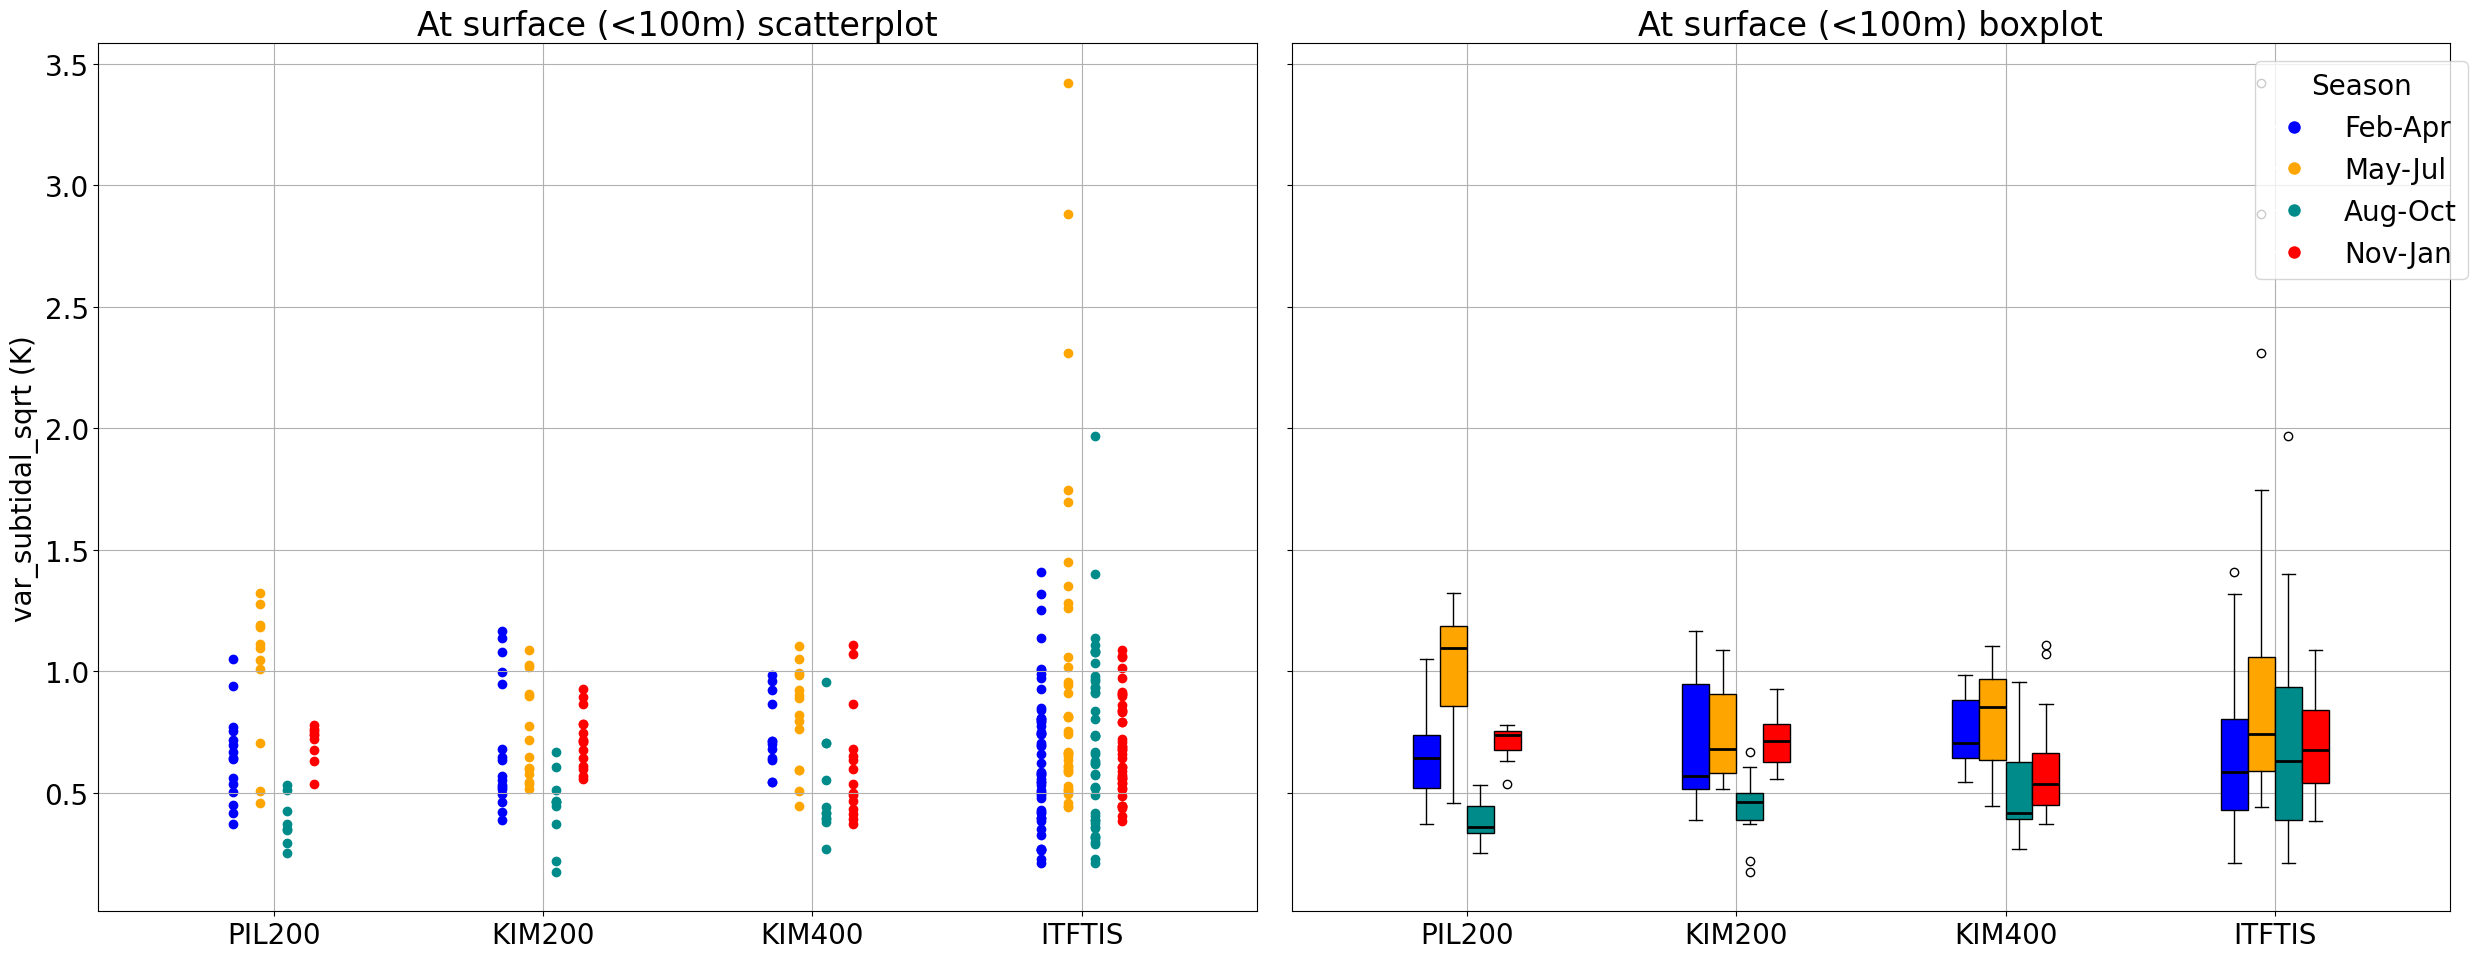

In [239]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['var_subtidal_sqrt']
lat_list = [-19.44,-17.76,-15.53,-15.22,-9.817,]
threshold = 40 #m
# Create a box plot
#PLOT
cols = 2
rows = 1
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(rows, cols, figsize=(25, 10),sharey='row',sharex=True)
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 


for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #select the data at the depth >-50m
            data_at_surface = data.loc[(data['depth_round'] > -100)][parameter_name].values
            x_positions = np.full(len(data_at_surface), i + j * width)
            #plot scatter for depth of max η_c
            axes[parameter_order*2].scatter(x_positions, data_at_surface, color=colors[j])
            
            #plot boxplot for whole depth
            if len(data_at_surface)>4:
                axes[parameter_order*2+1].boxplot(data_at_surface,
                            positions=[i + j * width], 
                            widths=width, patch_artist=True,
                            boxprops=dict(facecolor=colors[j]),
                            medianprops=dict(color='black', linewidth=2))
            
        axes[parameter_order*2].set_ylabel('{} ({})'.format(parameter_name,M1L2_parameter_units[parameter_order]))
                              
    
# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=season_legend[season], markersize=10) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.7,0.7), bbox_to_anchor=(0.91, 0.7))  

axes[0].set_title('At surface (<100m) scatterplot')
axes[1].set_title('At surface (<100m) boxplot')

for axe in axes:
    axe.set_xticks(positions + (len(seasons) - 1) * width / 2)
    axe.set_xticklabels(locations)
    axe.grid(True)
    

# Show plot
plt.tight_layout()
# # plt.savefig('Seasonal_variability_of_M1L2_parameter_at_max_eta.pdf')
# plt.show()

## For particular parameter 

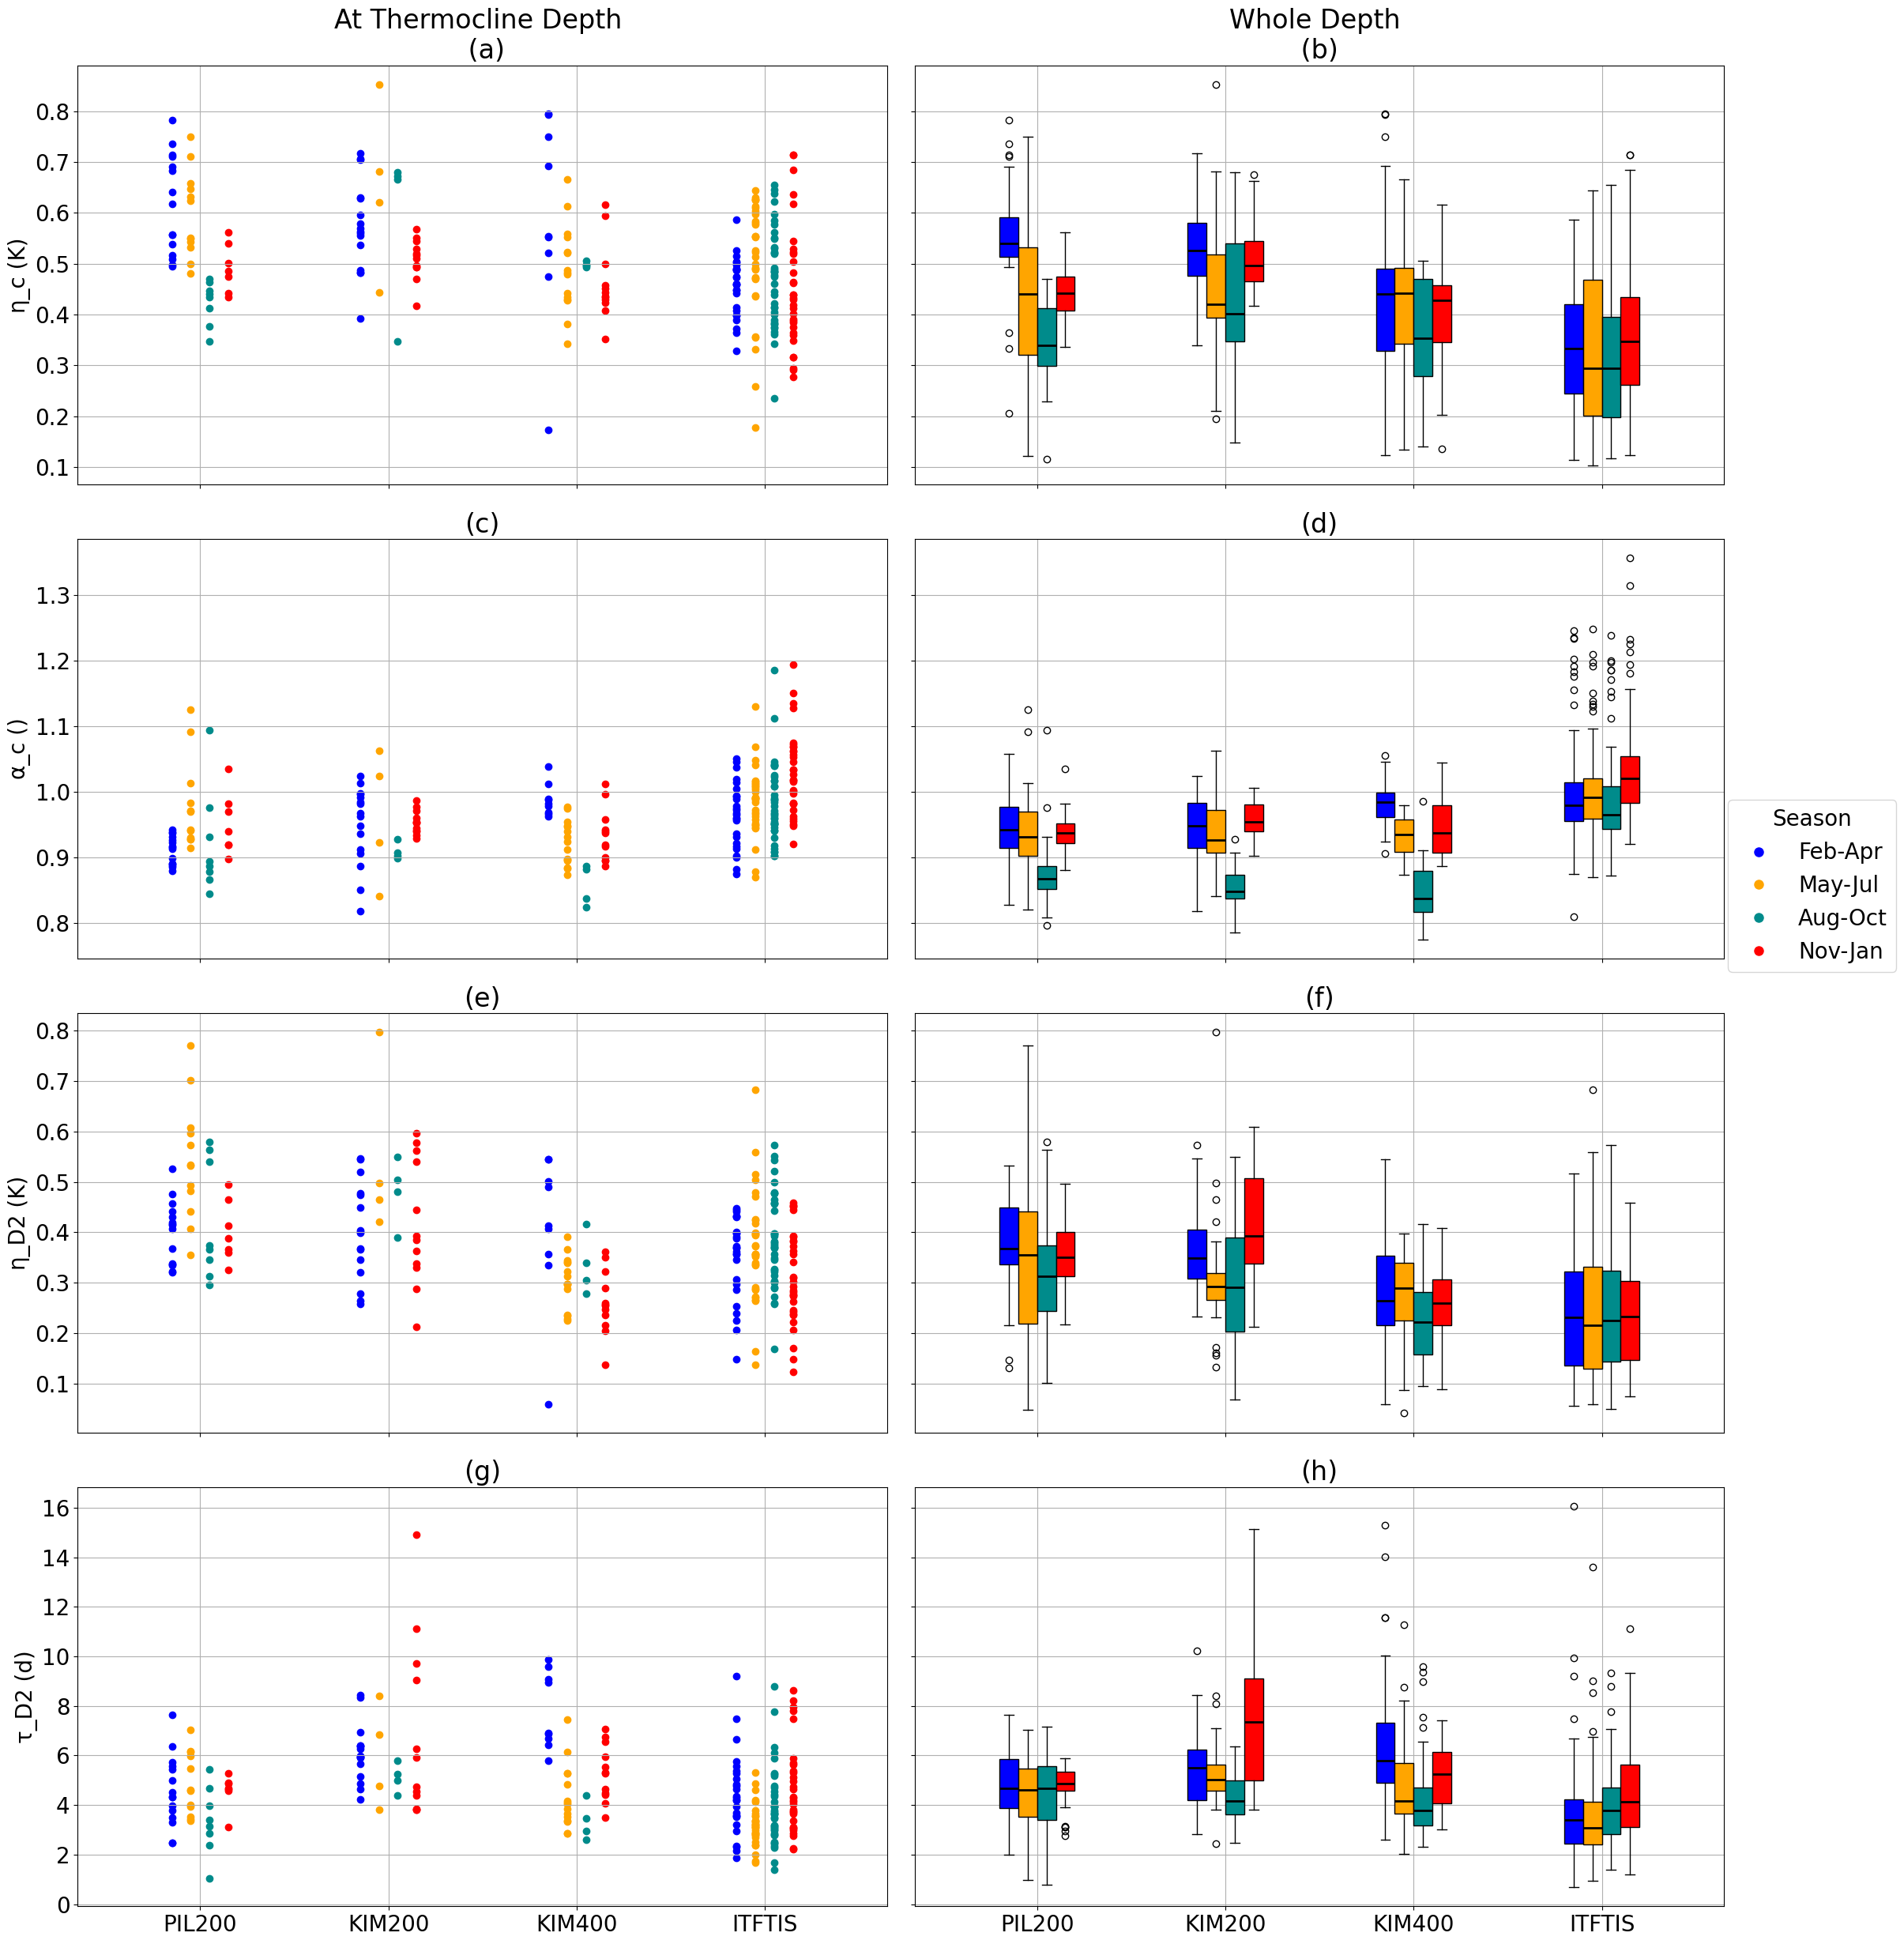

In [203]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D2','τ_D2']
M1L2_parameter_order = ['a', 'b', 'c', 'd', 'e', 'f','g','h','i','j','k']
M1L2_parameter_units = [  'K','', 'K','d' ]
lat_list = [-19.44, -15.53,-15.22, -9.817,]
threshold = 40 #m
# Create a box plot
#PLOT
cols = 2
rows = len(M1L2_parameter_name)
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(rows, cols, figsize=(25, 25),sharey='row',sharex=True)
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 


for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[(Whole_Soln_df_M1L2_clean['site'] =='{}'.format(loc)) & (Whole_Soln_df_M1L2_clean['season'] =='{}'.format(season))].copy()
            #find the depth of max η_c
            max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
            #select the data at the depth of max η_c
            data_at_η_max = data.loc[(data['depth_round'] > max_value_depth_down)
                                &(data['depth_round'] < max_value_depth_up)]
            #plot for data_at_η_max
            x_positions = np.full(len(data_at_η_max), i + j * width)
            axes[parameter_order*2].scatter(x_positions, data_at_η_max[parameter_name].values, color=colors[j])
            #plot for data_at_whole depth
            data_whole = data
            if len(data_whole)>4:
                axes[parameter_order*2+1].boxplot(data_whole[parameter_name].values,
                            positions=[i + j * width], 
                            widths=width, patch_artist=True,
                            boxprops=dict(facecolor=colors[j]),
                            medianprops=dict(color='black', linewidth=2))
            
        axes[parameter_order*2].set_ylabel('{} ({})'.format(parameter_name,M1L2_parameter_units[parameter_order]))
                              
    
# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=season_legend[season], markersize=10) for season in seasons]
labels = seasons
fig.legend(handles, labels, title='Season', loc=(0.8,0.5), bbox_to_anchor=(0.89, 0.5))  

for i in range(len(axes)):
    axe = axes[i]
    axe.set_title(f'({M1L2_parameter_order[i]})')
    axe.set_xticks(positions + (len(seasons) - 1) * width / 2)
    axe.set_xticklabels(locations)
    axe.grid(True)
    
axes[0].set_title('At Thermocline Depth \n (a)')
axes[1].set_title('Whole Depth \n (b) ')
    
# Show plot
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle to leave space for the y-axis label and legend
# Show plot
plt.savefig('Seasonal_variability_of_selected_M1L2_parameter_at_max_eta_and_whole_depth.pdf')
plt.show()

## Subtidal Variance

# Box plots of each year for each location pair

## KIM400 & ITFTIS

In [ ]:
# locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['KIM400','ITFTIS']
lat_list = [-15.22, -9.817,]
bin_size = 20 #m
#find the whole depth list
depth_list = np.arange(Whole_Soln_df_M1L2_clean['depth_round'].min(),Whole_Soln_df_M1L2_clean['depth_round'].max()+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1','τ_D1', 'η_D2',  'τ_D2']
M1L2_parameter_order = ['a','b','c','d','e','f','g']
# Plot box plot
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors = ['blue', 'orange', 'darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        #find the data at this location
        data = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==loc].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            data_at_depth = data.loc[(data['depth_round'] >= (depth-bin_size)) & (data['depth_round'] < (depth)) & (data['year'] == 2018)][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            #check data length
            axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
        # Customize plot
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
#       axes[parameter_order].set_xlabel('Value')
        axes[parameter_order].set_ylabel('Depth')
        axes[parameter_order].set_yticks(depth_order_list[::2])  # Display every fifth depth
        axes[parameter_order].set_yticklabels(depth_list[::2])       # Set labels for every fifth depth
        axes[parameter_order].grid(True)

# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(locations, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in locations]
labels = locations   
axes[1].legend(handles, labels, loc=(0.8,0.02), title='Sites') 


for i in [1,3,5]:
    axes[i].set_ylabel('')
    axes[i].yaxis.set_ticklabels([])
    axes[i].yaxis.set_ticks_position('none')
for i in [4,5]:
    axes[i].set_xlabel('Value')
    
# Show plot
plt.tight_layout()
# plt.savefig('KIM400&ITFTIS depth profile of M1L2 parameter.pdf')
plt.show()

In [ ]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['KIM400','ITFTIS']
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D1',   'τ_D1','η_D2', 'τ_D2']
lat_list = [-15.22, -9.817,]
threshold = 40 #m
# Create a box plot
#PLOT
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[
                (Whole_Soln_df_M1L2_clean['site'] == '{}'.format(loc))
                & (Whole_Soln_df_M1L2_clean['season'] == '{}'.format(season))
                &(Whole_Soln_df_M1L2_clean['year'] == 2018)].copy()
            
            if len(data) == 0:
                print('there is no data at this year at {}'.format(loc))
            else:
                max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
                #select the data at the depth of max η_c
                data = data.loc[(data['depth_round'] > max_value_depth_down)
                            &(data['depth_round'] < max_value_depth_up)][parameter_name].values
                data_clean = [x for x in data if not np.isnan(x)]
                axes[parameter_order].boxplot(data_clean,
                                                  positions=[i + j * width], 
                                                  widths=width, patch_artist=True,
                                                  boxprops=dict(facecolor=colors[j]),
                                                  medianprops=dict(color='red', linewidth=2))

                    # Customize plot
    axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))                                 
    axes[parameter_order].set_xticks(positions + (len(seasons) - 1) * width / 2)
    axes[parameter_order].set_xticklabels(locations)
    axes[parameter_order].set_ylabel('Value')
    axes[parameter_order].grid(True)    

# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Rectangle((0,0),1,1, color=season_legend[season]) for season in seasons]
labels = seasons
axes[1].legend(handles, labels, title='Season')          

for i in [1,3,5]:
    axes[i].set_ylabel('')
for i in [0,1,2,3]:
    axes[i].xaxis.set_ticklabels([])
    axes[i].xaxis.set_ticks_position('none')
    
# Show plot
plt.tight_layout()
# plt.savefig('Seasonal variability of M1L2 parameter at max eta.pdf')
plt.show()

## KIM200 & PIL200

In [ ]:
locations = ['KIM200','PIL200']
lat_list = [-15.53,-19.44,]
#find the whole depth list
bin_size = 20
depth_list = np.arange(-210,Whole_Soln_df_M1L2_clean['depth_round'].max()/2+1,bin_size)  #positive, from shallow to deep
M1L2_parameter_name = ['η_c','α_c','η_D1','τ_D1', 'η_D2',   'τ_D2']

# Plot box plot
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
axes = axes.flatten()
# Plot box plots for each location
# Set a thinner width
width = 0.25 
colors =  ['darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        #find the data at this location
        data = Whole_Soln_df_M1L2_clean.loc[Whole_Soln_df_M1L2_clean['site'] ==loc].copy()
        #depth_order is used to identify the location of yticks and box
        depth_order_list = []
        for depth_order, depth in enumerate(depth_list):
            #provide the position for ticks
            depth_order_list.append(depth_order)
            data_at_depth = data.loc[(data['depth_round'] >= (depth-bin_size)) & (data['depth_round'] < (depth)) & (data['year'] == 2014)][parameter_name].values  
            #select the non-nan values
            data_clean = [x for x in data_at_depth if not np.isnan(x)]
            #check data length
            axes[parameter_order].boxplot(data_clean,
                                            positions=[depth_order + i* width], 
                                            widths=width, 
                                            patch_artist=True,
                                            boxprops=dict(facecolor=colors[i]),
                                            medianprops=dict(color='black', linewidth=2),
                                            vert=False)
        # Customize plot
        axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))
#       axes[parameter_order].set_xlabel('Value')
        axes[parameter_order].set_ylabel('Depth')
        axes[parameter_order].set_yticks(depth_order_list[::2])  # Display every fifth depth
        axes[parameter_order].set_yticklabels(depth_list[::2])       # Set labels for every fifth depth
        axes[parameter_order].grid(True)

# Create a custom legend for the locations
location_legend = {location: color for location, color in zip(locations, colors)}
handles = [plt.Rectangle((0,0),1,1, color=location_legend[location]) for location in locations]
labels = locations   
axes[1].legend(handles, labels, loc=(0.8,0.02), title='Sites') 


for i in [1,3,5]:
    axes[i].set_ylabel('')
    axes[i].yaxis.set_ticklabels([])
    axes[i].yaxis.set_ticks_position('none')
for i in [4,5]:
    axes[i].set_xlabel('Value')
    
# Show plot
plt.tight_layout()
# plt.savefig('KIM400&ITFTIS depth profile of M1L2 parameter.pdf')
plt.show()

In [ ]:
#depths for max η_c
locations = Whole_Soln_df_M1L2_clean ['site'].drop_duplicates()
locations = ['KIM200','PIL200']
seasons =Whole_Soln_df_M1L2_clean ['season'].drop_duplicates()
M1L2_parameter_name = ['η_c','α_c','η_D1',   'τ_D1','η_D2', 'τ_D2']
lat_list = [-15.22, -9.817,]
threshold = 40 #m
# Create a box plot
#PLOT
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()
# Plot box plots for each location and season
positions = np.arange(len(locations))
width = 0.1  # Set a thinner width
colors = ['blue', 'orange', 'darkcyan','red'] 

for parameter_order,parameter_name in enumerate(M1L2_parameter_name):
    for i, loc in enumerate(locations):
        for j, season in enumerate(seasons):
            data = Whole_Soln_df_M1L2_clean.loc[
                (Whole_Soln_df_M1L2_clean['site'] == '{}'.format(loc))
                & (Whole_Soln_df_M1L2_clean['season'] == '{}'.format(season))
                &(Whole_Soln_df_M1L2_clean['year'] == 2014)].copy()
            
            if len(data) == 0:
                print('there is no data at this year at {}'.format(loc))
            else:
                max_value_depth_up, max_value_depth_down = find_max_η_depth(data,lat_list[i],threshold)
                #select the data at the depth of max η_c
                data = data.loc[(data['depth_round'] > max_value_depth_down)
                            &(data['depth_round'] < max_value_depth_up)][parameter_name].values
                data_clean = [x for x in data if not np.isnan(x)]
                axes[parameter_order].boxplot(data_clean,
                                                  positions=[i + j * width], 
                                                  widths=width, patch_artist=True,
                                                  boxprops=dict(facecolor=colors[j]),
                                                  medianprops=dict(color='red', linewidth=2))

                    # Customize plot
    axes[parameter_order].set_title('({}) {}'.format(M1L2_parameter_order[parameter_order],parameter_name))                                 
    axes[parameter_order].set_xticks(positions + (len(seasons) - 1) * width / 2)
    axes[parameter_order].set_xticklabels(locations)
    axes[parameter_order].set_ylabel('Value')
    axes[parameter_order].grid(True)    

# Create a custom legend for the seasons
season_legend = {season: color for season, color in zip(seasons, colors)}
handles = [plt.Rectangle((0,0),1,1, color=season_legend[season]) for season in seasons]
labels = seasons
axes[1].legend(handles, labels, title='Season')          

for i in [1,3,5]:
    axes[i].set_ylabel('')
for i in [0,1,2,3]:
    axes[i].xaxis.set_ticklabels([])
    axes[i].xaxis.set_ticks_position('none')
    
# Show plot
plt.tight_layout()
# plt.savefig('Seasonal variability of M1L2 parameter at max eta.pdf')
plt.show()